https://docs.google.com/forms/d/e/1FAIpQLScV1jxroXYj4vGc3otSNB5pAOO-ga4iLe6qEWO6iSpTI_W0xQ/viewform

![notebook_image](notebook_image.jpg)


# Executive Summary
I model factuality detection of AI-generated educational answers as a **3-class Natural Language Inference (NLI) problem**. After **EDA**, I choose a hybrid approach, combining **lexicographical features** with features extracted through **pre-trained models**. I choose to train a **stacking ensemble**, employing 4 base learners (Boosting, Gaussian Naive Bayes, linear SVM, Random Forest, Softmax regression) and a shallow **Multi-Layer Perceptron (MLP)** as a meta-learner. 

**Analyzing the base learners' errors**, I conclude that they are different enough that ensembling is a useful.

Using **permutation-based feature imporance**, I identify the most important features before transifitioning into a **full-scale interpretability/explainability analysis using SHAP values and an EBM as a surrogate model**.

Overall, I demonstrate that the **extracted meta-features from the base learners** alone contain enough signal to achieve competitive performance, yet the boost compared to the strongest base learner - in this case the boosting model - is marginal.

**The final performance of the ensemble on the test set is 0.92 (macro-F1 score).**

**Recommendations for NLI and Factuality Detection:**
- **Feature Hybridization:** Combine traditional lexical features (length, overlap) with deep-learning embeddings (SBERT) and specialized NLI model probabilities. This captures both the structural and semantic nuances of factuality.
- **Focus on Logic-Driven Meta-Features:** Prioritize features that detect logical inconsistency given answer length or other features as these can be the deciding factors in distinguishing between the three classes contradiction, factual, and irrelevant.
- **Ensemble Diversity over Complexity:** Utilize base learners with diverse underlying mathematical assumptions (e.g., Naive Bayes vs. Gradient Boosting). The meta-learner (MLP) benefits more from the varied error patterns of these models than from simply adding more similar learners.

# Configuration & Setup
Imports all needed libraries and creates all constants used in the notebook

In [1]:
# Standard library imports
import json
import re
import os
import importlib.util
from pathlib import Path

# External libraries and Model Persistence
import joblib
from joblib import load

# Data processing and math
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint, loguniform

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from pandas.plotting import parallel_coordinates
from IPython.display import Markdown, display
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Scikit-learn: Preprocessing & Model Selection
from sklearn.model_selection import (
    StratifiedKFold, 
    train_test_split, 
    RandomizedSearchCV, 
    cross_val_predict
)
from sklearn.preprocessing import (
    MinMaxScaler, 
    StandardScaler, 
    PowerTransformer, 
    LabelEncoder, 
    normalize
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.base import clone
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Scikit-learn: Models & Ensembles
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (
    HistGradientBoostingClassifier, 
    RandomForestClassifier, 
    StackingClassifier
)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Scikit-learn: Metrics & Inspection
from sklearn.metrics import (
    f1_score, 
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    make_scorer
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.utils.class_weight import compute_sample_weight

# NLP & Deep Learning
import spacy
from sentence_transformers import SentenceTransformer
from transformers import pipeline

# InterpretML (Explainable AI)
if importlib.util.find_spec("interpret") is None:
    !pip install interpret
from interpret.glassbox import ExplainableBoostingClassifier
import shap

# Constants & Styling
TRAFFIC_LIGHTS = {
    "factual": "#2ca02c",      
    "contradiction": "#d62728",  
    "irrelevant": "#ffdd57"    
}
TARGET = "type"

# Feature Groupings
FEAT_LEXICAL = [
    "question_len", "context_len", "answer_len", 
    "len_ratio", "answer_unique_ratio", "cap_mismatch_count"
]
FEAT_LOGIC = [
    "jaccard_sim", "overlap_answer_context", "overlap_answer_question", 
    "answer_novelty", "negation_count", "hedge_count", "uncertainty_flag", 
    "numerical_count", "num_consistency_score", "numeric_relative_error", 
    "answer_type_mismatch"
]
FEAT_EVIDENCE = [
    "semantic_sim", "best_sentence_sim", "evidence_entropy"
]
FEAT_TOPICS = [f"topic_{i}_prob" for i in range(15)] + ["topic_kl_divergence"]
FEAT_DEEP_LEARNING = [
    "sbert_sim_answer_context", "nli_entailment", "nli_contradiction", 
    "nli_neutral", "ner_match_ratio", "ans_nouns", "ans_verbs"
]
CATEGORICAL = ["q_category", "answer_type", "question_type"]
FINAL_FEATURES = FEAT_LEXICAL + FEAT_LOGIC + FEAT_EVIDENCE + FEAT_TOPICS + FEAT_DEEP_LEARNING + CATEGORICAL
FEATURE_SETS = {
    "Lexical": FEAT_LEXICAL + CATEGORICAL,
    "Lexical + Logic": FEAT_LEXICAL + FEAT_LOGIC + CATEGORICAL,
    "Lexical + Logic + Evidence": FEAT_LEXICAL + FEAT_LOGIC + FEAT_EVIDENCE + CATEGORICAL,
    "Lexical + Logic + Evidence + Topics": (FEAT_LEXICAL + FEAT_LOGIC + FEAT_EVIDENCE + FEAT_TOPICS + CATEGORICAL),
    "Full Model (+Deep Learning)": FINAL_FEATURES
}

# Model Parameters 
BEST_HGB_PARAMS = {
    'l2_regularization': 1.0461985740299486,
    'learning_rate': 0.33728132143073974,
    'max_depth': 16,
    'max_iter': 637,
    'max_leaf_nodes': 52,
    'min_samples_leaf': 10
}
BEST_GNB_PRIORS = [0.33, 0.34, 0.33]
BEST_GNB_SMOOTHING = 1e-09
BEST_SGD_PARAMS = {
    'alpha': np.float64(0.012802257679575171), 
    'eta0': np.float64(3.5972330810492434), 
    'l1_ratio': np.float64(0.498195716453139), 
    'learning_rate': 'adaptive', 
    'max_iter': 2989, 
    'penalty': 'elasticnet'
}
BEST_RF_PARAMS = {
    'bootstrap': True, 
    'max_depth': 17, 
    'max_features': 'sqrt', 
    'min_samples_leaf': 1, 
    'min_samples_split': 5, 
    'n_estimators': 400
}
BEST_LOGREG_PARAMS = {
    'C': 0.054502936945582565,
    'l1_ratio': 0.7851759613930136,
    'max_iter': 2399,
    'penalty': 'elasticnet',
    'multi_class': 'multinomial',
    'solver': 'saga',
    'class_weight': 'balanced',
    'random_state': 42
}
SKF = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

NB_VERSION = "lexical_plus_logic"
FULL_VERSION = "full_model_(plusdeep_learning)"
LOAD_MAP = {
    "Boosting": f"intermediate_results/hgb_{FULL_VERSION}.joblib",
    "NB": f"intermediate_results/gnb_{NB_VERSION}.joblib",
    "SVM": f"intermediate_results/sgd_{FULL_VERSION}.joblib",
    "RF": f"intermediate_results/rf_{FULL_VERSION}.joblib",
    "Softmax": f"intermediate_results/logreg_{FULL_VERSION}.joblib"
}
NB_FEATURES = FEAT_LEXICAL + FEAT_LOGIC + CATEGORICAL
FULL_FEATURES = FINAL_FEATURES
LOAD_MAP2 = {
    "hgb": "intermediate_results/hgb_full_model_(plusdeep_learning).joblib",
    "rf": "intermediate_results/rf_full_model_(plusdeep_learning).joblib",
    "sgd": "intermediate_results/sgd_full_model_(plusdeep_learning).joblib",
    "gnb": "intermediate_results/gnb_lexical_plus_logic.joblib",
    "logreg": "intermediate_results/logreg_full_model_(plusdeep_learning).joblib"
}

2025-12-29 14:14:11.793994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767017651.809729    1601 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767017651.814768    1601 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767017651.828213    1601 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767017651.828228    1601 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767017651.828231    1601 computation_placer.cc:177] computation placer alr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 125.8 MB/s  0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 16.8 MB/s  0:00:00m0:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 6.1 MB/s  0:00:01 eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 8.9 MB/s  0:00:01m eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.3 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 57.0 MB/s  0:00:00
  Created wheel for dash-cytoscape: filename=dash_cytoscape-1.0.2-py3-none-any.whl size=4010811 sha256=9def582911c57bc0fbfdcebe98717b6ada8a1285f773dcf384275335b03f5e3d
  Stored in directory: /home/repl/.cache/pip/wheels/0c/db/f6/9dcb225e9adf45dfef713542769556b1f508170a0759053892
Successfully built dash-cytoscape
  Attempting uninstall: Werkzeug90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  3/15 [zope.interface]
    Found existing installation: Werkzeug 3.1.3━━━━

In [2]:
# Load data with basic error handling
data_path = "data/train.json"

try:
    with open(data_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    train_df = pd.DataFrame(data)
except FileNotFoundError:
    print(f"Error: The file {data_path} was not found.")
except json.JSONDecodeError:
    print(f"Error: Failed to decode JSON from {data_path}.")

# **Exploratory Data Analysis**

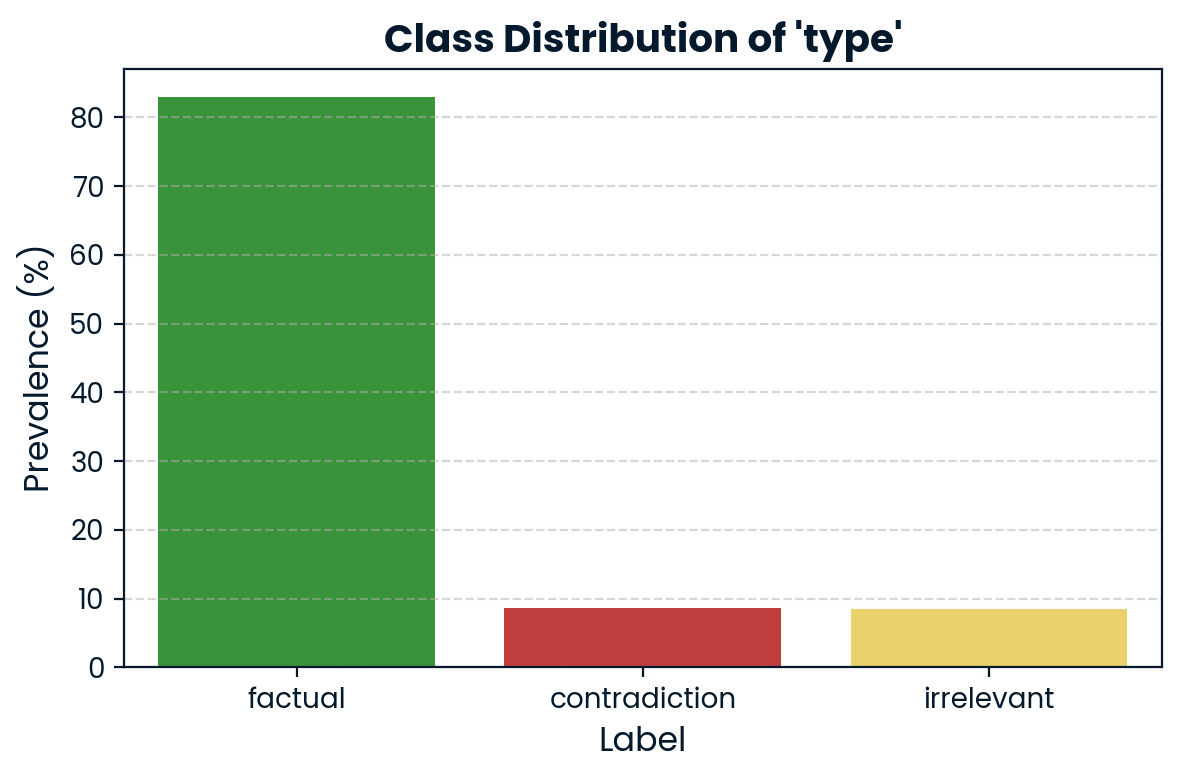

In [3]:
# Compute prevalence
class_props = train_df["type"].value_counts(normalize=True)

# Create color mapping
colors = [TRAFFIC_LIGHTS.get(label, "gray") for label in class_props.index]

plt.figure(figsize=(6, 4))
sns.barplot(x=class_props.index, y=class_props.values * 100, palette=colors, hue=class_props.index, legend=False)
plt.title("Class Distribution of 'type'", fontsize=14, fontweight='bold')
plt.xlabel("Label", fontsize=12)
plt.ylabel("Prevalence (%)", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The dataset exhibits extreme class imbalance for the 'type' target, with approximately **80% factual answers** and only about **10% contradiction** and **10% irrelevant** cases. This makes overall accuracy a misleading metric and motivates the use of **macro-averaged evaluation measures** and **class-weighted loss functions** to ensure that minority classes are not ignored during training - this is also in line with the evaluation metric mentioned in the challenge instructions. 

**I will therefore later optimize Macro-F1 score and use stratified cross validation.**

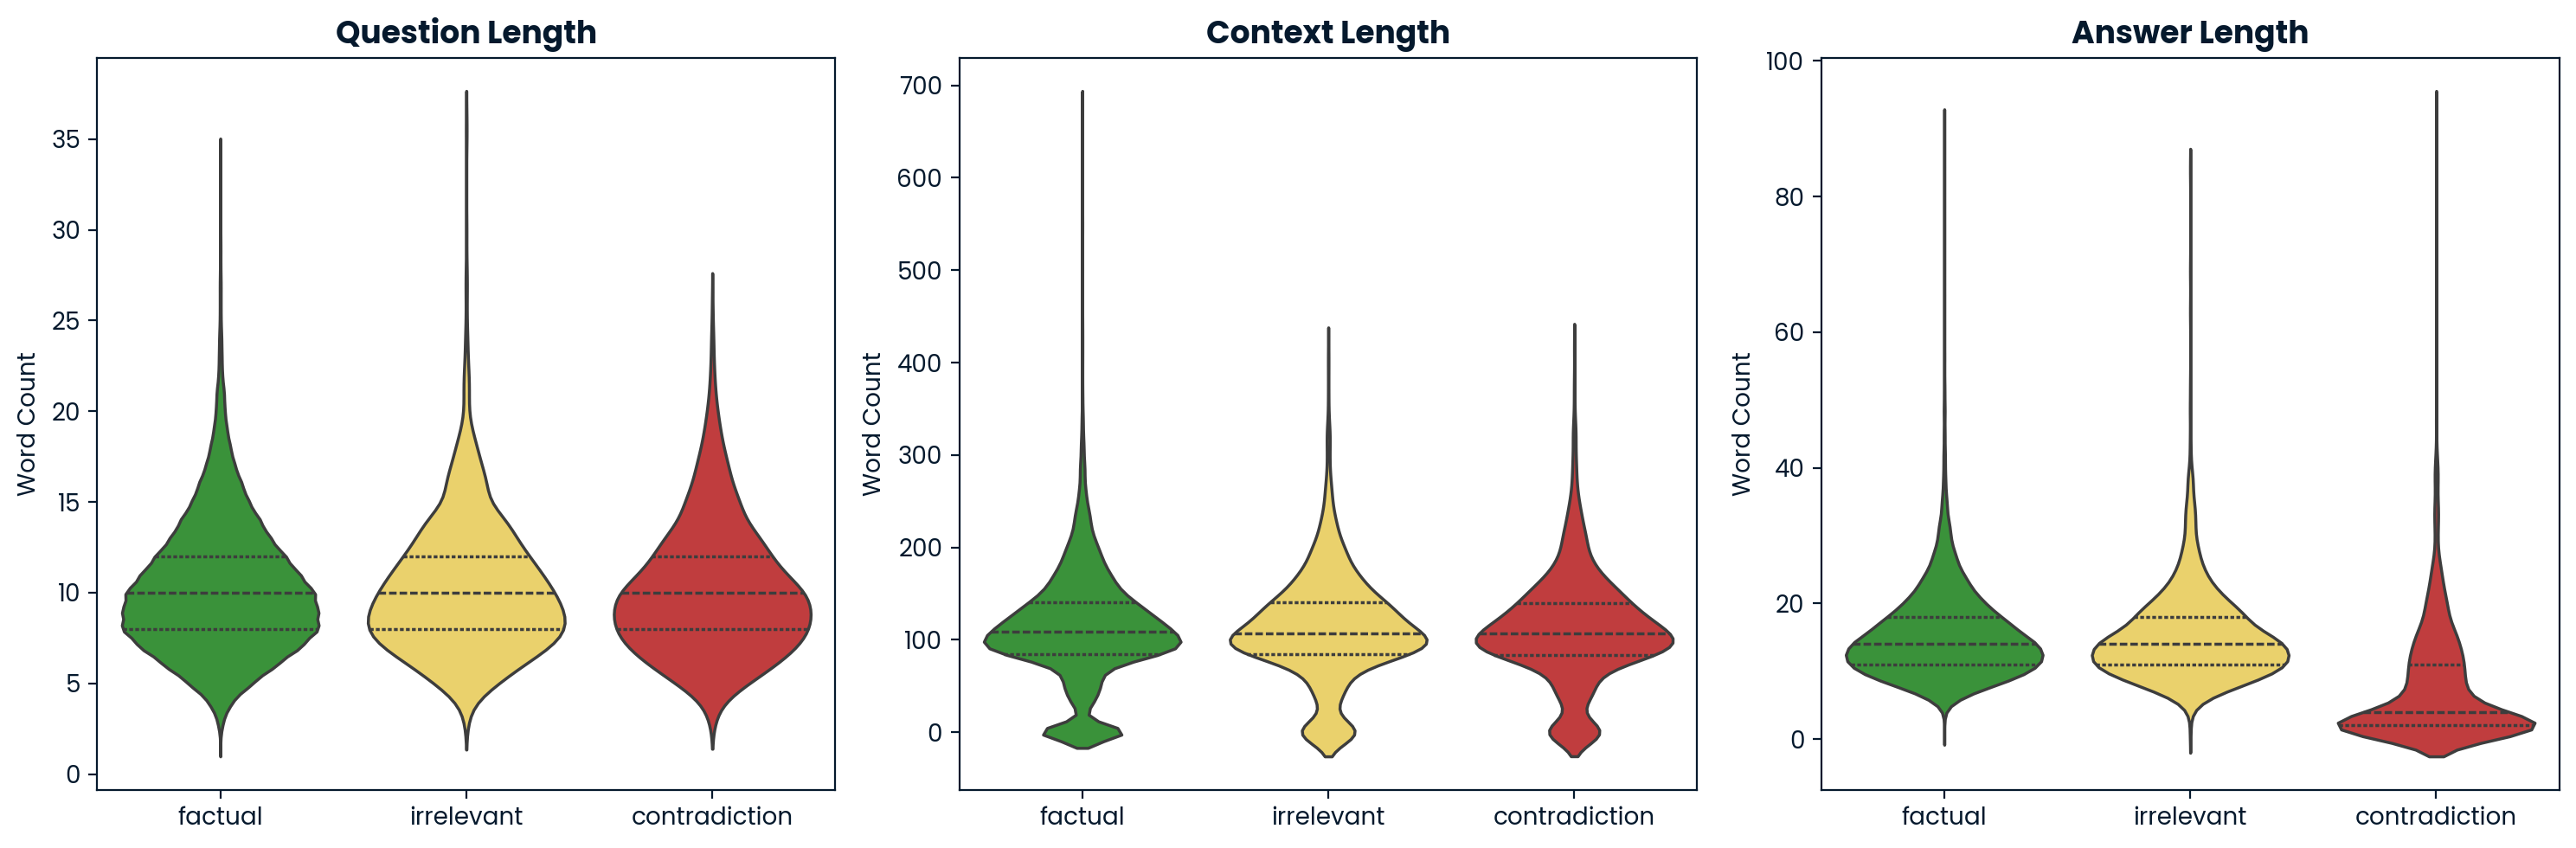

In [4]:
# Helper function for tokenization and counting
def count_words(text):
    if pd.isna(text): return 0
    return len(re.findall(r"\b\w+\b", str(text).lower()))

# Apply function to create length features
train_df["question_len"] = train_df["question"].apply(count_words)
train_df["context_len"] = train_df["context"].apply(count_words)
train_df["answer_len"] = train_df["answer"].apply(count_words)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
cols = ["question_len", "context_len", "answer_len"]
titles = ["Question Length", "Context Length", "Answer Length"]
for i, col in enumerate(cols):
    sns.violinplot(
        x="type", y=col, data=train_df, 
        ax=axes[i], palette=TRAFFIC_LIGHTS, inner="quartile", hue="type", legend=False
    )
    axes[i].set_title(titles[i], fontsize=13, fontweight='bold')
    axes[i].set_ylabel("Word Count")
    axes[i].set_xlabel("")
plt.tight_layout()
plt.show()

Looking at the most basic feature - length of question, context, and answer - I find that **question length distributions are highly similar**, indicating that the phrasing of the question makes little difference. The same is true for **context lengths**. 

However, **answer lengths** differ substantially by class, contradictory answers are usually much shorter on average. 

The substantial overlap between distributions suggests that **answer length alone is insufficient for reliable classification**, suggesting more advanced features are needed.

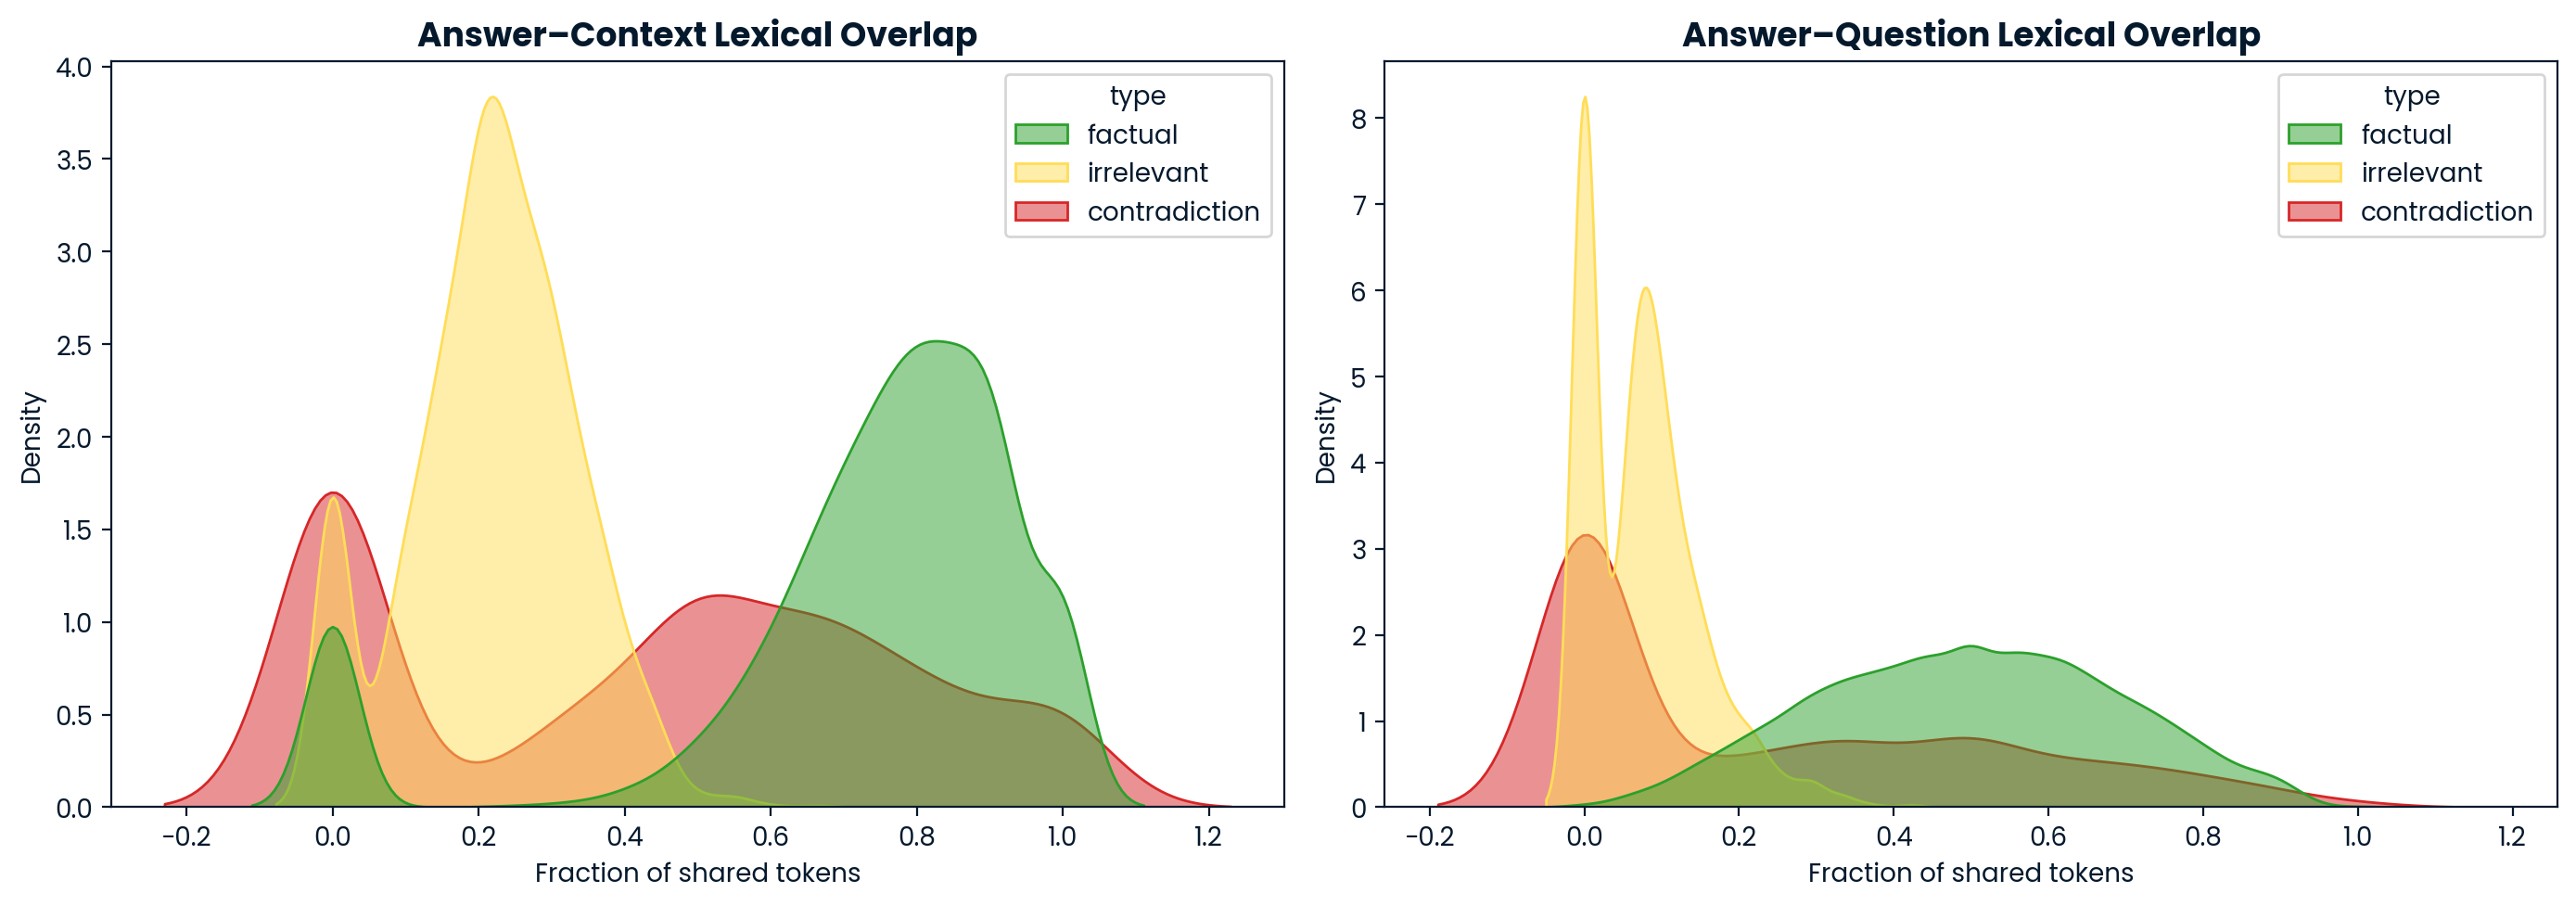

In [5]:
# Helper function to get set of unique lowercase words
def get_token_set(text):
    if pd.isna(text): return set()
    return set(re.findall(r"\b\w+\b", str(text).lower()))

# Pre-compute sets for efficiency
a_sets = train_df["answer"].apply(get_token_set)
c_sets = train_df["context"].apply(get_token_set)
q_sets = train_df["question"].apply(get_token_set)

# Compute overlaps (Intersection / Size of Answer Set)
train_df["overlap_answer_context"] = [
    len(a & c) / max(1, len(a)) for a, c in zip(a_sets, c_sets)
]
train_df["overlap_answer_question"] = [
    len(a & q) / max(1, len(a)) for a, q in zip(a_sets, q_sets)
]

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
overlap_cols = ["overlap_answer_context", "overlap_answer_question"]
titles = ["Answer–Context Lexical Overlap", "Answer–Question Lexical Overlap"]
for i, col in enumerate(overlap_cols):
    sns.kdeplot(
        data=train_df, x=col, hue="type", 
        fill=True, palette=TRAFFIC_LIGHTS, ax=axes[i], 
        common_norm=False, alpha=0.5
    )
    axes[i].set_title(titles[i], fontsize=13, fontweight='bold')
    axes[i].set_xlabel("Fraction of shared tokens")
plt.tight_layout()
plt.show()

**Answer–Context lexical overlap** is highest for factual answers, indicating that correct responses tend to reuse a substantial portion of the contextual evidence. This is usually not true for irrelevant or wrong answers.

**Answer–Question overlap** further separates classes: factual answers strongly align with the question focus, while irrelevant answers show near-zero overlap, consistent with generic or off-topic responses.

Overall, **lexical overlap** could be highly effective for **detecting irrelevance**, but insufficient for reliably distinguishing **factual answers from contradictions**.

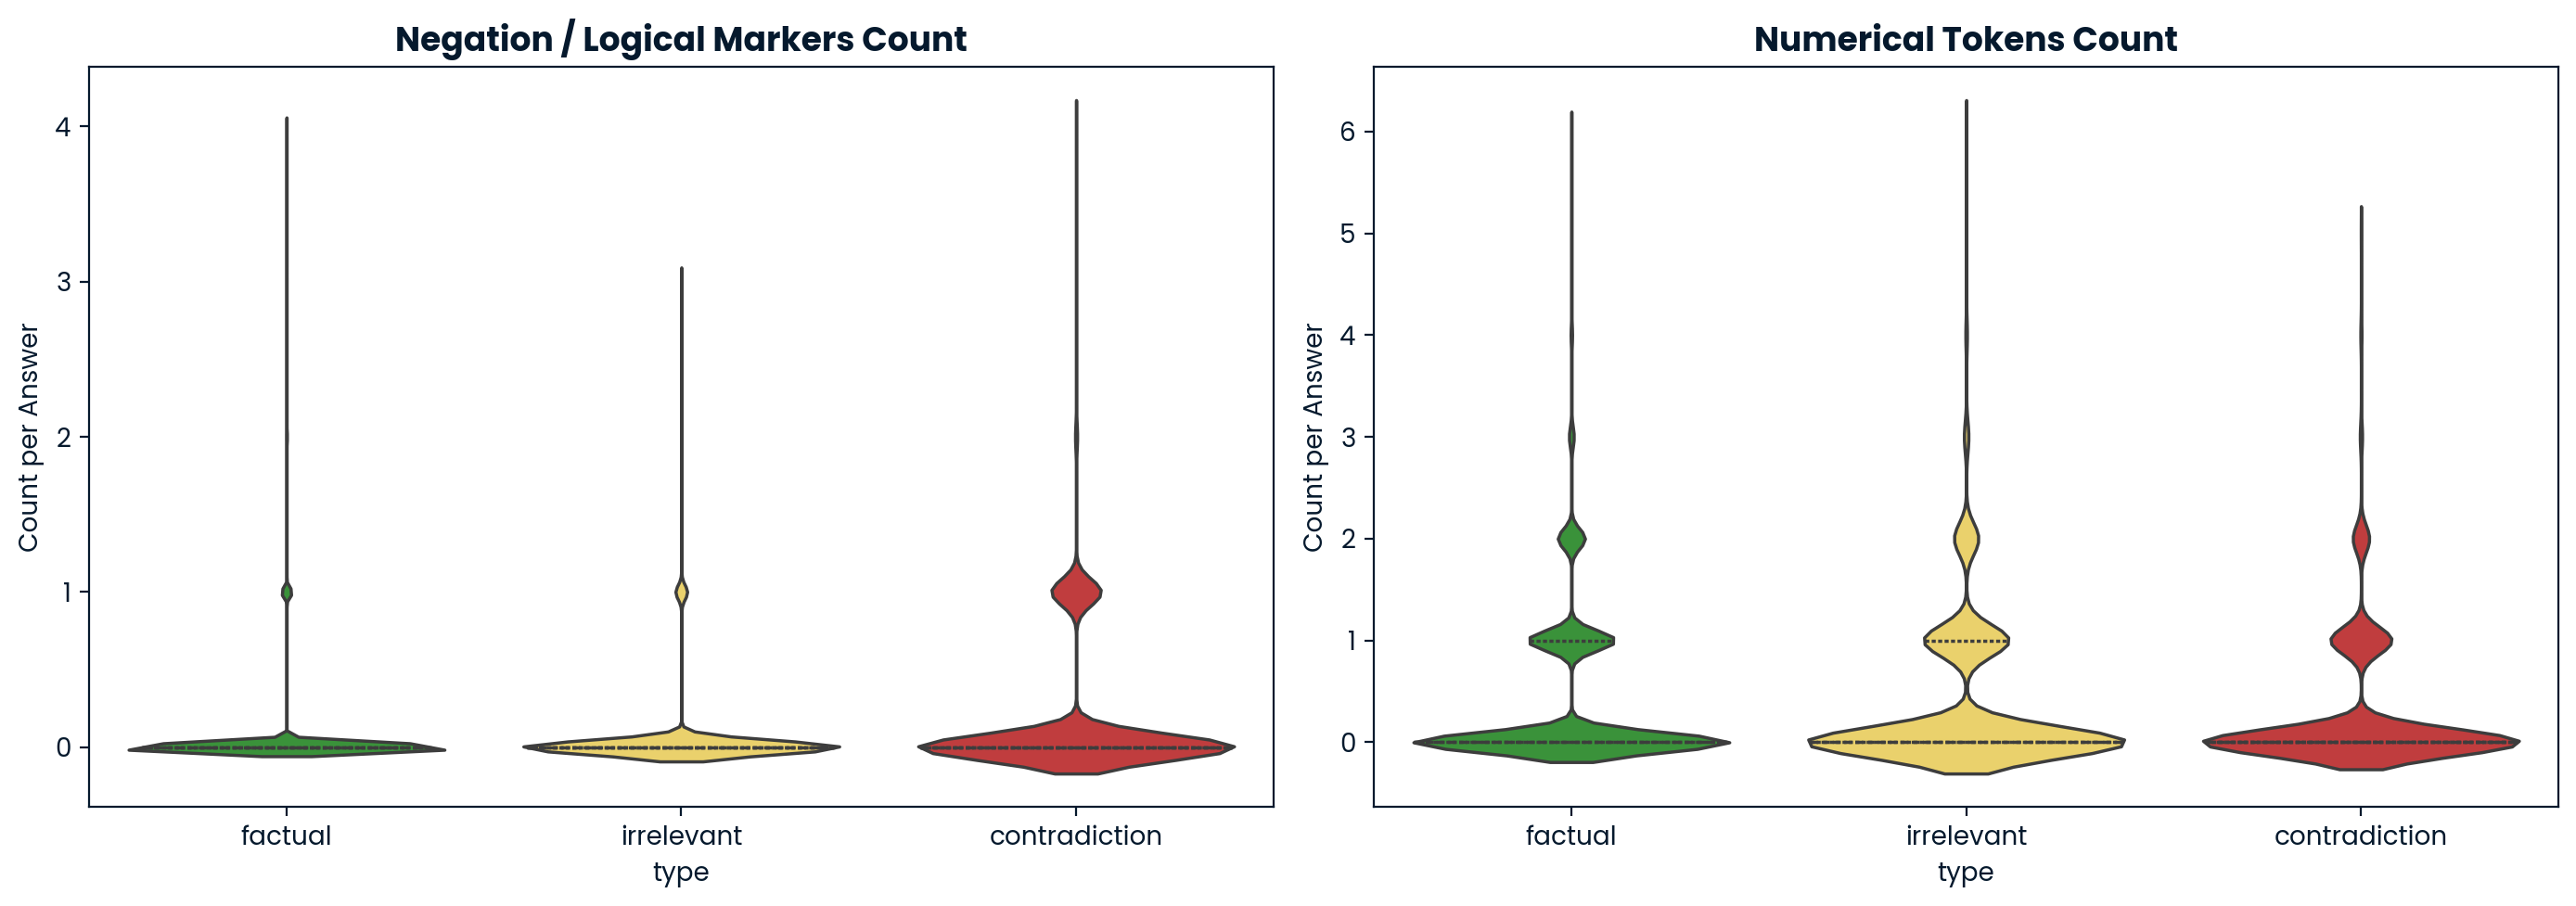

In [6]:
# Logic Features: Negation & Numerical Counts
negation_tokens = ["not", "never", "no", "except", "false", "incorrect", "cannot", "can't", "wrong"]
neg_pattern = r'\b(' + '|'.join(negation_tokens) + r')\b'
train_df["negation_count"] = train_df["answer"].apply(
    lambda x: len(re.findall(neg_pattern, str(x).lower()))
)

# Robust numerical token pattern (handles decimals and percentages)
train_df["numerical_count"] = train_df["answer"].apply(
    lambda x: len(re.findall(r"\b\d+[\.,]?\d*%?\b", str(x)))
)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.violinplot(
    x="type", y="negation_count", data=train_df, 
    ax=axes[0], palette=TRAFFIC_LIGHTS, inner="quartile", hue="type", legend=False
)
axes[0].set_title("Negation / Logical Markers Count", fontsize=13, fontweight='bold')
axes[0].set_ylabel("Count per Answer")
sns.violinplot(
    x="type", y="numerical_count", data=train_df, 
    ax=axes[1], palette=TRAFFIC_LIGHTS, inner="quartile", hue="type", legend=False
)
axes[1].set_title("Numerical Tokens Count", fontsize=13, fontweight='bold')
axes[1].set_ylabel("Count per Answer")
plt.tight_layout()
plt.show()

The frequency of **negation markers and numerical tokens** are surprisingly **not different** much different between classes.

Contrary to the belief that numbers and negations drive LLM confusion, high overlap across all types demonstrates that **negation and numerical proxies alone are weak discriminators**.

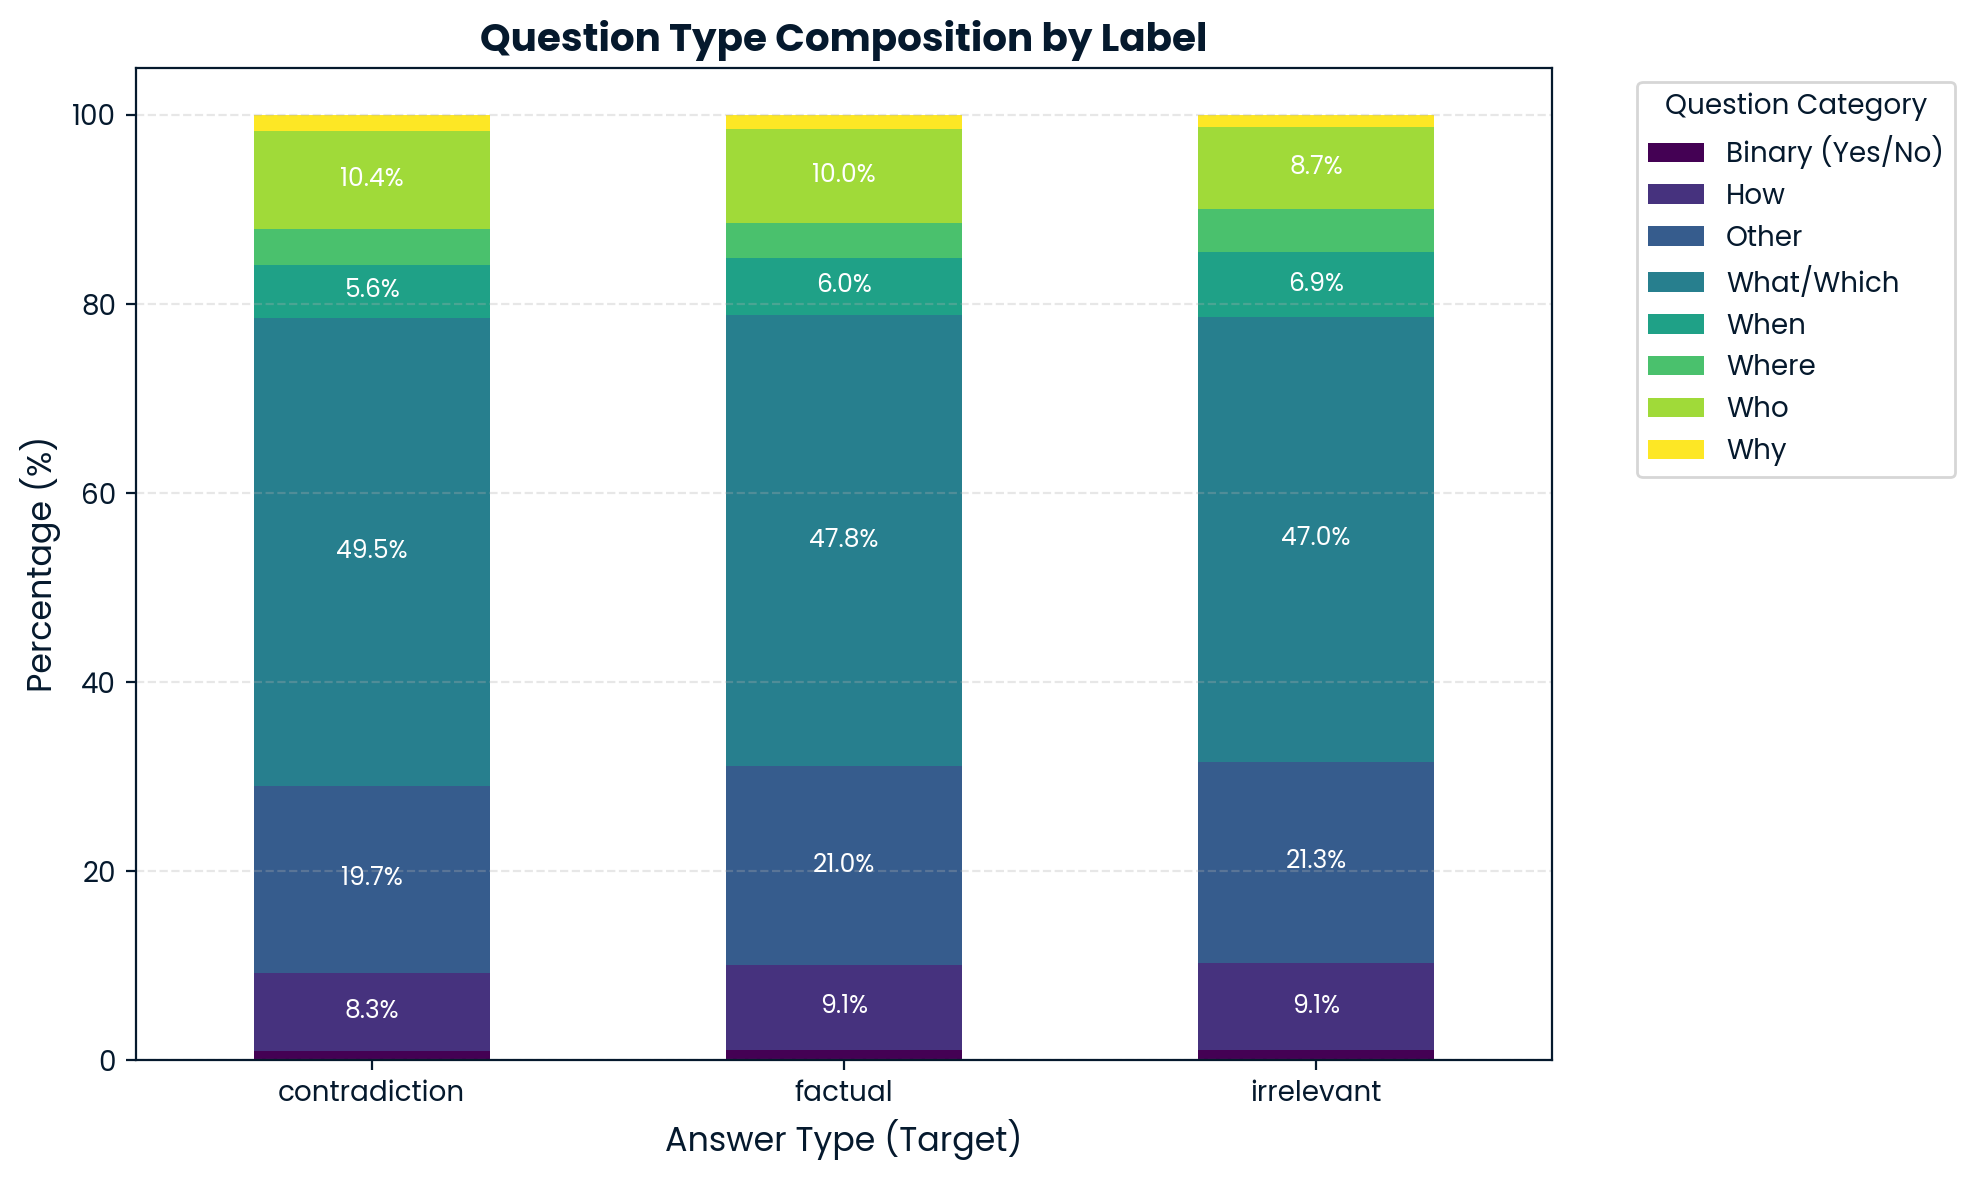

In [7]:
# Question Categorization
def get_q_type(q):
    q = str(q).lower().strip()
    if q.startswith(("what", "which")): return "What/Which"
    if q.startswith("who"):            return "Who"
    if q.startswith("where"):          return "Where"
    if q.startswith("when"):           return "When"
    if q.startswith("why"):            return "Why"
    if q.startswith("how"):            return "How"
    if q.startswith(("is", "are", "do", "does", "can", "could", "was", "were", "will")): 
        return "Binary (Yes/No)"
    return "Other"

train_df["q_category"] = train_df["question"].apply(get_q_type)

# Visualization
q_dist = (
    train_df.groupby("type")["q_category"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0) * 100
)
ax = q_dist.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="viridis")
plt.title("Question Type Composition by Label", fontsize=14, fontweight='bold')
plt.ylabel("Percentage (%)", fontsize=12)
plt.xlabel("Answer Type (Target)", fontsize=12)
plt.legend(title="Question Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 5: # Only label segments larger than 5%
        x, y = p.get_xy() 
        ax.text(x+width/2, y+height/2, f'{height:.1f}%', ha='center', va='center', color='white', fontsize=9)
plt.tight_layout()
plt.show()

The 'WH-' question profile is remarkably consistent in its distribution across 'type', with **'what' questions** dominating at approximately 60% in all categories.

Thus, the phrasing of the question (e.g., 'who' vs 'how') is likely **not a good predictive feature by itself** for model errors or factuality. 

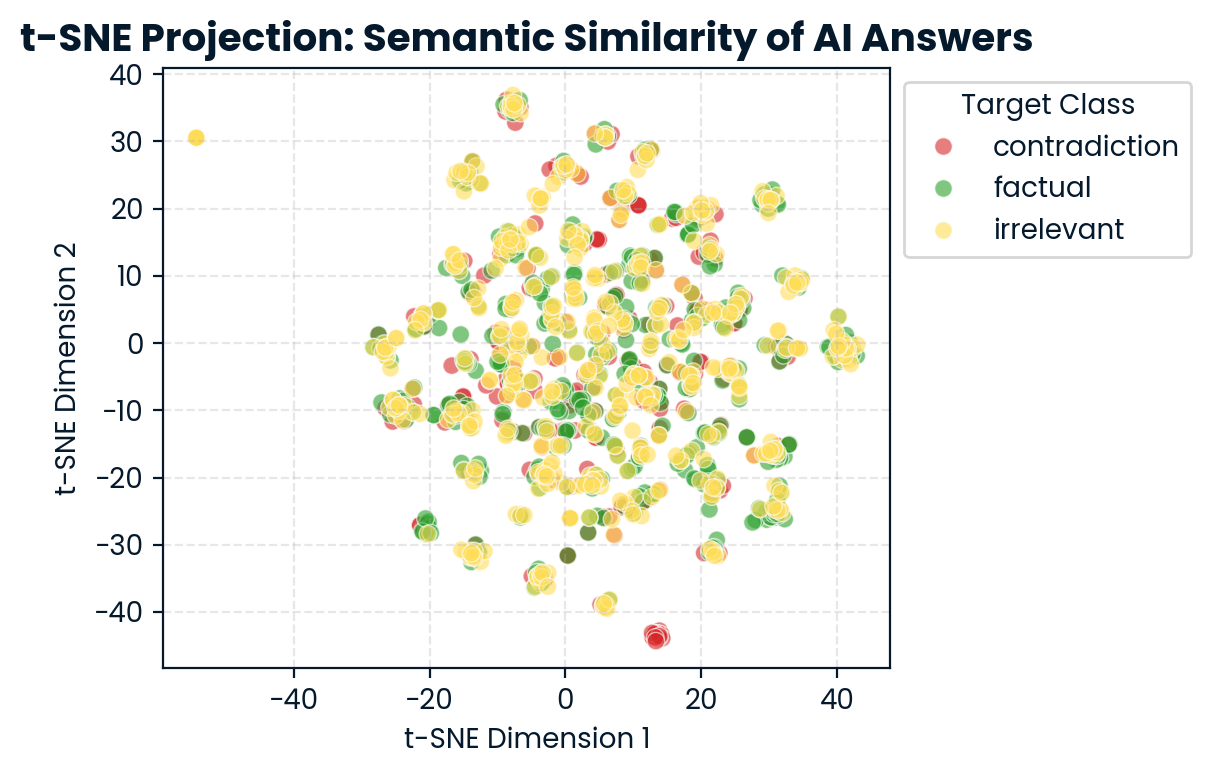

In [8]:
# Sampling for t-SNE while maintaining class proportions
tsne_sample = train_df.groupby('type', group_keys=False).apply(
    lambda x: x.sample(min(600, len(x)), random_state=42)
)

# Text vectorization using TF-IDF 
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X_tfidf = vectorizer.fit_transform(tsne_sample['answer'].astype(str))

# Dimensionality reduction using SVD
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)
tsne = TSNE(
    n_components=2, 
    random_state=42, 
    perplexity=30, 
    learning_rate='auto',
    init='pca',
    metric='cosine'
)
X_tsne = tsne.fit_transform(X_reduced)

# Visualization
plt.figure(figsize=(6, 4))
sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1], 
    hue=tsne_sample['type'], 
    palette=TRAFFIC_LIGHTS, 
    s=40, alpha=0.6, edgecolors='w', linewidth=0.5
)
plt.title("t-SNE Projection: Semantic Similarity of AI Answers", fontsize=14, fontweight='bold')
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Target Class", loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

**High Class Overlap:** The t-SNE projection shows substantial overlap between **factual**, **contradiction**, and **irrelevant** answers, with no clearly separable clusters by label. This indicates that answer texts across classes are **not just lexically but also semantically similar** when represented using TF-IDF. 

**Task Implication:** The observed overlap suggests that model errors and contradictions arise from **context–answer relationships and truth conditions**, but can also partially be seen through stylistic or vocabulary-level differences in the answers. In the following, I intend to create more sophisticated features, which (hopefully) will in sum be able to predict the 'type' label accurately.

# Feature Engineering

This section provides an overview of the engineered features used to characterize the relationship between **question**, **context**, and **answer**. The features are organized into coherent groups.

---

### 🔤 Lexical / Text-Based Features
- **`question_len`, `context_len`, `answer_len`:**  
  Raw token counts for each text segment, computed using a regex-based `count_words` function.
- **`len_ratio`:**  
  Ratio of answer length to context length.
- **`answer_unique_ratio`:**  
  Proportion of unique words in the answer.
- **`cap_mismatch_count`:**  
  Number of capitalized words in the answer that do **not** appear in the context.
- **`q_category`:**  
  Categorical intent of the question (*Who, What/Which, When, Where, Why, How, Binary, Other*).

---

### 🧠 Semantic / Similarity Features
- **`semantic_sim`:**  
  Cosine similarity between normalized TF-IDF vectors of the context and the answer.
- **`best_sentence_sim`:**  
  Maximum similarity score between the answer and any individual sentence in the context.
- **`evidence_entropy`:**  
  Entropy of the sentence-level similarity distribution, measuring how *concentrated* the evidence is.

---

### 🔗 Logic / Overlap Features
- **`jaccard_sim`:**  
  Token-level Jaccard similarity (Intersection over Union) between answer and context.
- **`overlap_answer_context`, `overlap_answer_question`:**  
  Proportion of unique answer tokens found in the context and in the question, respectively.
- **`answer_novelty`:**  
  Inverse of context overlap, defined as  
  \[
  1 - \text{overlap\_answer\_context}
  \]
  indicating the amount of new information introduced by the answer.
- **`negation_count`:**  
  Frequency of negation tokens (e.g., *not*, *never*, *cannot*).
- **`hedge_count`:**  
  Frequency of uncertainty or hedging words (e.g., *might*, *possibly*).
- **`uncertainty_flag`:**  
  Binary indicator (1 if `hedge_count > 0`).
- **`numerical_count`:**  
  Number of numeric tokens in the answer (including decimals and percentages).
- **`num_consistency_score`:**  
  Proportion of numeric values in the answer that also appear in the context.
- **`numeric_relative_error`:**  
  Minimum relative error between numeric values in the answer and those in the context.

---

### ❓ Answer / Question Type Features
- **`answer_type`, `question_type`:**  
  Inferred data types (e.g., *Number, Boolean, List, Entity*).
- **`answer_type_mismatch`:**  
  Binary flag indicating whether the inferred answer type contradicts the expected question type.

---

### 🧩 Topic / Latent Semantic Features
- **`topic_0_prob` … `topic_14_prob`:**  
  Probabilities of 15 latent topics inferred using Latent Dirichlet Allocation (LDA).
- **`topic_kl_divergence`:**  
  Kullback–Leibler divergence between the topic distributions of the answer and the context.

---

### 🧠 Syntactic / Named Entity Features
- **`ans_nouns`:**  
  Number of noun tokens in the answer.
- **`ans_verbs`:**  
  Number of verb tokens in the answer.
- **`ner_match_ratio`:**  
  Proportion of named entities in the answer that are successfully matched in the context.

---

### 🤖 Deep Learning / NLI Features
- **`nli_entailment`, `nli_contradiction`, `nli_neutral`:**  
  Probability scores from a Natural Language Inference (NLI) model assessing whether the answer is entailed by, contradicts, or is neutral with respect to the context.
- **`sbert_sim_answer_context`:**  
  Semantic similarity computed using pre-trained Sentence-BERT embeddings.

In [9]:
# Load data
train_df = pd.read_json("data/train.json") 
test_df = pd.read_json("data/test.json")

# Helper functions
def count_words(text):
    if pd.isna(text): return 0
    return len(re.findall(r"\b\w+\b", str(text).lower()))

def get_token_set(text):
    if pd.isna(text): return set()
    return set(re.findall(r"\b\w+\b", str(text).lower()))

def cap_mismatch(answer, context):
    a_caps = {w for w in re.findall(r'\b[A-Z][a-z]+\b', str(answer))}
    c_caps = {w for w in re.findall(r'\b[A-Z][a-z]+\b', str(context))}
    return len(a_caps - c_caps)
    
def get_rel_error(a_list, c_list):
    if not a_list or not c_list: return 0.0
    return min(abs(float(ai) - float(cj)) / max(1.0, float(cj)) for ai in a_list for cj in c_list)

def get_val_type(text):
    t = str(text).lower().strip()
    if re.fullmatch(r'\d+', t): return 'number'
    if t in ['yes', 'no']:      return 'boolean'
    if ',' in t:                return 'list'
    return 'entity'

def get_q_type(q):
    q = str(q).lower().strip()
    if q.startswith(("what", "which")): return "What/Which"
    if q.startswith("who"):            return "Who"
    if q.startswith("where"):          return "Where"
    if q.startswith("when"):           return "When"
    if q.startswith("why"):            return "Why"
    if q.startswith("how"):            return "How"
    if q.startswith(("is", "are", "do", "does", "can", "could", "was", "were", "will")): 
        return "Binary (Yes/No)"
    return "Other"

def get_nlp_features(text):
    if not str(text).strip(): return set(), 0, 0
    doc = nlp(str(text))
    entities = {ent.text.lower() for ent in doc.ents}
    noun_count = sum(1 for token in doc if token.pos_ == "NOUN")
    verb_count = sum(1 for token in doc if token.pos_ == "VERB")
    return entities, noun_count, verb_count

# Feature engineering pipeline
def apply_feature_engineering(df, tfidf_model, lda_model, count_vectorizer, dl_features_path):
    # Load spacy
    nlp = spacy.load("en_core_web_sm", disable=["parser", "lemmatizer"])

    # Lexical and text-based features
    df["q_category"] = df["question"].apply(get_q_type)
    df["question_len"] = df["question"].apply(count_words)
    df["context_len"] = df["context"].apply(count_words)
    df["answer_len"] = df["answer"].apply(count_words)
    df['len_ratio'] = df['answer_len'] / (df['context_len'] + 1)
    df["answer_unique_ratio"] = df["answer"].apply(
        lambda x: len(set(get_token_set(x))) / max(1, count_words(x))
    )
    df["cap_mismatch_count"] = df.apply(
        lambda r: cap_mismatch(r["answer"], r["context"]), axis=1
    )
    
    # Semantic and similarity
    ctx_vecs = normalize(tfidf_model.transform(df['context'].fillna("").astype(str)))
    ans_vecs = normalize(tfidf_model.transform(df['answer'].fillna("").astype(str)))
    df['semantic_sim'] = np.array((ctx_vecs.multiply(ans_vecs)).sum(axis=1)).flatten()

    def sentence_level_stats(row):
        sents = re.split(r'(?<=[.!?])\s+', str(row['context']))
        if not sents or not str(row['answer']).strip(): return 0.0, 0.0
        a_vec = tfidf_model.transform([str(row['answer'])])
        s_vecs = tfidf_model.transform(sents)
        sims = cosine_similarity(a_vec, s_vecs)[0]
        p = (sims + 1e-9) / (sims.sum() + 1e-9)
        return sims.max(), -np.sum(p * np.log(p))

    df['best_sentence_sim'], df['evidence_entropy'] = zip(*df.apply(sentence_level_stats, axis=1))

    # Logic and overlap
    a_sets = df["answer"].apply(get_token_set)
    c_sets = df["context"].apply(get_token_set)
    q_sets = df["question"].apply(get_token_set)
    
    df["jaccard_sim"] = [len(a & c) / len(a | c) if (a or c) else 0 for a, c in zip(a_sets, c_sets)]
    df["overlap_answer_context"] = [len(a & c) / max(1, len(a)) for a, c in zip(a_sets, c_sets)]
    df["overlap_answer_question"] = [len(a & q) / max(1, len(a)) for a, q in zip(a_sets, q_sets)]
    df['answer_novelty'] = 1 - df['overlap_answer_context']

    negation_tokens = ["not", "never", "no", "except", "false", "incorrect", "cannot", "can't", "wrong"]
    neg_pattern = r'\b(' + '|'.join(negation_tokens) + r')\b'
    HEDGE_WORDS = {"may", "might", "could", "possibly", "likely", "uncertain", "unclear", "not sure", "cannot determine", "depends", "unknown"}
    
    df["negation_count"] = df["answer"].apply(lambda x: len(re.findall(neg_pattern, str(x).lower())))
    df['hedge_count'] = df['answer'].apply(lambda x: sum(1 for w in HEDGE_WORDS if w in str(x).lower()))
    df['uncertainty_flag'] = (df['hedge_count'] > 0).astype(int)
    
    num_pattern = r"\b\d+[\.,]?\d*%?\b"
    df["numerical_count"] = df["answer"].apply(lambda x: len(re.findall(num_pattern, str(x))))
    
    ans_nums = [set(re.findall(r'\d+', str(a))) for a in df['answer']]
    ctx_nums = [set(re.findall(r'\d+', str(c))) for c in df['context']]
    df['num_consistency_score'] = [len(a & c) / len(a) if a else 1.0 for a, c in zip(ans_nums, ctx_nums)]
    df['numeric_relative_error'] = [get_rel_error(re.findall(r'\d+', str(a)), re.findall(r'\d+', str(c))) for a, c in zip(df['answer'], df['context'])]

    # Type features
    df['answer_type'] = df['answer'].apply(get_val_type)
    df['question_type'] = df['question'].apply(get_val_type)
    df['answer_type_mismatch'] = (df['answer_type'] != df['question_type']).astype(int)

    # Topic features (LDA)
    ctx_topics = lda_model.transform(count_vectorizer.transform(df['context'].fillna("")))
    ans_topics = lda_model.transform(count_vectorizer.transform(df['answer'].fillna("")))
    for i in range(15):
        df[f'topic_{i}_prob'] = ctx_topics[:, i]
    df['topic_kl_divergence'] = [np.sum((p + 1e-9) * np.log((p + 1e-9) / (q + 1e-9))) for p, q in zip(ctx_topics, ans_topics)]

    # NLP Entity & POS features
    ans_data = df['answer'].apply(get_nlp_features)
    ctx_data = df['context'].apply(get_nlp_features)
    df['ans_entities'], df['ans_nouns'], df['ans_verbs'] = zip(*ans_data)
    df['ctx_entities'], _, _ = zip(*ctx_data)
    df['ner_match_ratio'] = df.apply(lambda r: len(r['ans_entities'].intersection(r['ctx_entities'])) / len(r['ans_entities']) if r['ans_entities'] else 1.0, axis=1)

    # Merge deep learning features
    if os.path.exists(dl_features_path):
        deep_df = pd.read_csv(dl_features_path)
    else:
        print("DL features not found. Running inference (This will take 15+ minutes)...")
        # ONLY run this if file is missing (will not be the case, just here for reproducibility)
        from sentence_transformers import SentenceTransformer
        from transformers import pipeline
        
        # Use 'train_df' variable name from earlier cells
        sbert = SentenceTransformer("all-MiniLM-L6-v2")
        ctx_emb = sbert.encode(df["context"].astype(str).tolist(), batch_size=32, show_progress_bar=True)
        ans_emb = sbert.encode(df["answer"].astype(str).tolist(), batch_size=32, show_progress_bar=True)
        
        # Calculate similarities
        sbert_sims = cosine_similarity(ans_emb, ctx_emb).diagonal()
        
        # NLI Pipeline
        nli = pipeline("text-classification", model="typeform/distilbert-base-uncased-mnli", device=-1)
        pairs = [f"{c} [SEP] {a}" for c, a in zip(df["context"], df["answer"])]
        out = nli(pairs, batch_size=4, truncation=True, max_length=512)
        
        # Build the dataframe
        deep_df = pd.DataFrame({
            "sbert_sim_answer_context": sbert_sims,
            "nli_entailment": [next(s["score"] for s in o if s["label"].lower()=="entailment") for o in out],
            "nli_contradiction": [next(s["score"] for s in o if s["label"].lower()=="contradiction") for o in out],
            "nli_neutral": [next(s["score"] for s in o if s["label"].lower()=="neutral") for o in out]
        })
        # Save it so it doesn not run again
        deep_df.to_csv(dl_features_path, index=False)
    df = pd.concat([df.reset_index(drop=True), deep_df.reset_index(drop=True)], axis=1)
    return df

# Define file paths
train_path = "intermediate_results/df_train.json"
test_path = "intermediate_results/df_test.json"

# Check if both files already exist
if os.path.exists(train_path) and os.path.exists(test_path):
    train_df = pd.read_json(train_path, orient="records")
    test_df = pd.read_json(test_path, orient="records")
else:
    # Fit on training data only
    train_text = pd.concat([train_df['context'], train_df['answer']]).fillna("").astype(str)
    tfidf_global = TfidfVectorizer(stop_words='english', max_features=1000).fit(train_text)

    topic_vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    term_matrix = topic_vectorizer.fit_transform(train_df['context'].fillna(""))
    lda_global = LatentDirichletAllocation(n_components=15, random_state=42).fit(term_matrix)

    # Run for train and test
    train_df = apply_feature_engineering(train_df, tfidf_global, lda_global, topic_vectorizer, "data/dl_features_train.csv")
    test_df = apply_feature_engineering(test_df, tfidf_global, lda_global, topic_vectorizer, "data/dl_features_test.csv")

    # Ensure the directory exists before saving
    os.makedirs("intermediate_results", exist_ok=True)

    # Save the dataframes
    train_df.to_json(train_path, orient="records")
    test_df.to_json(test_path, orient="records")

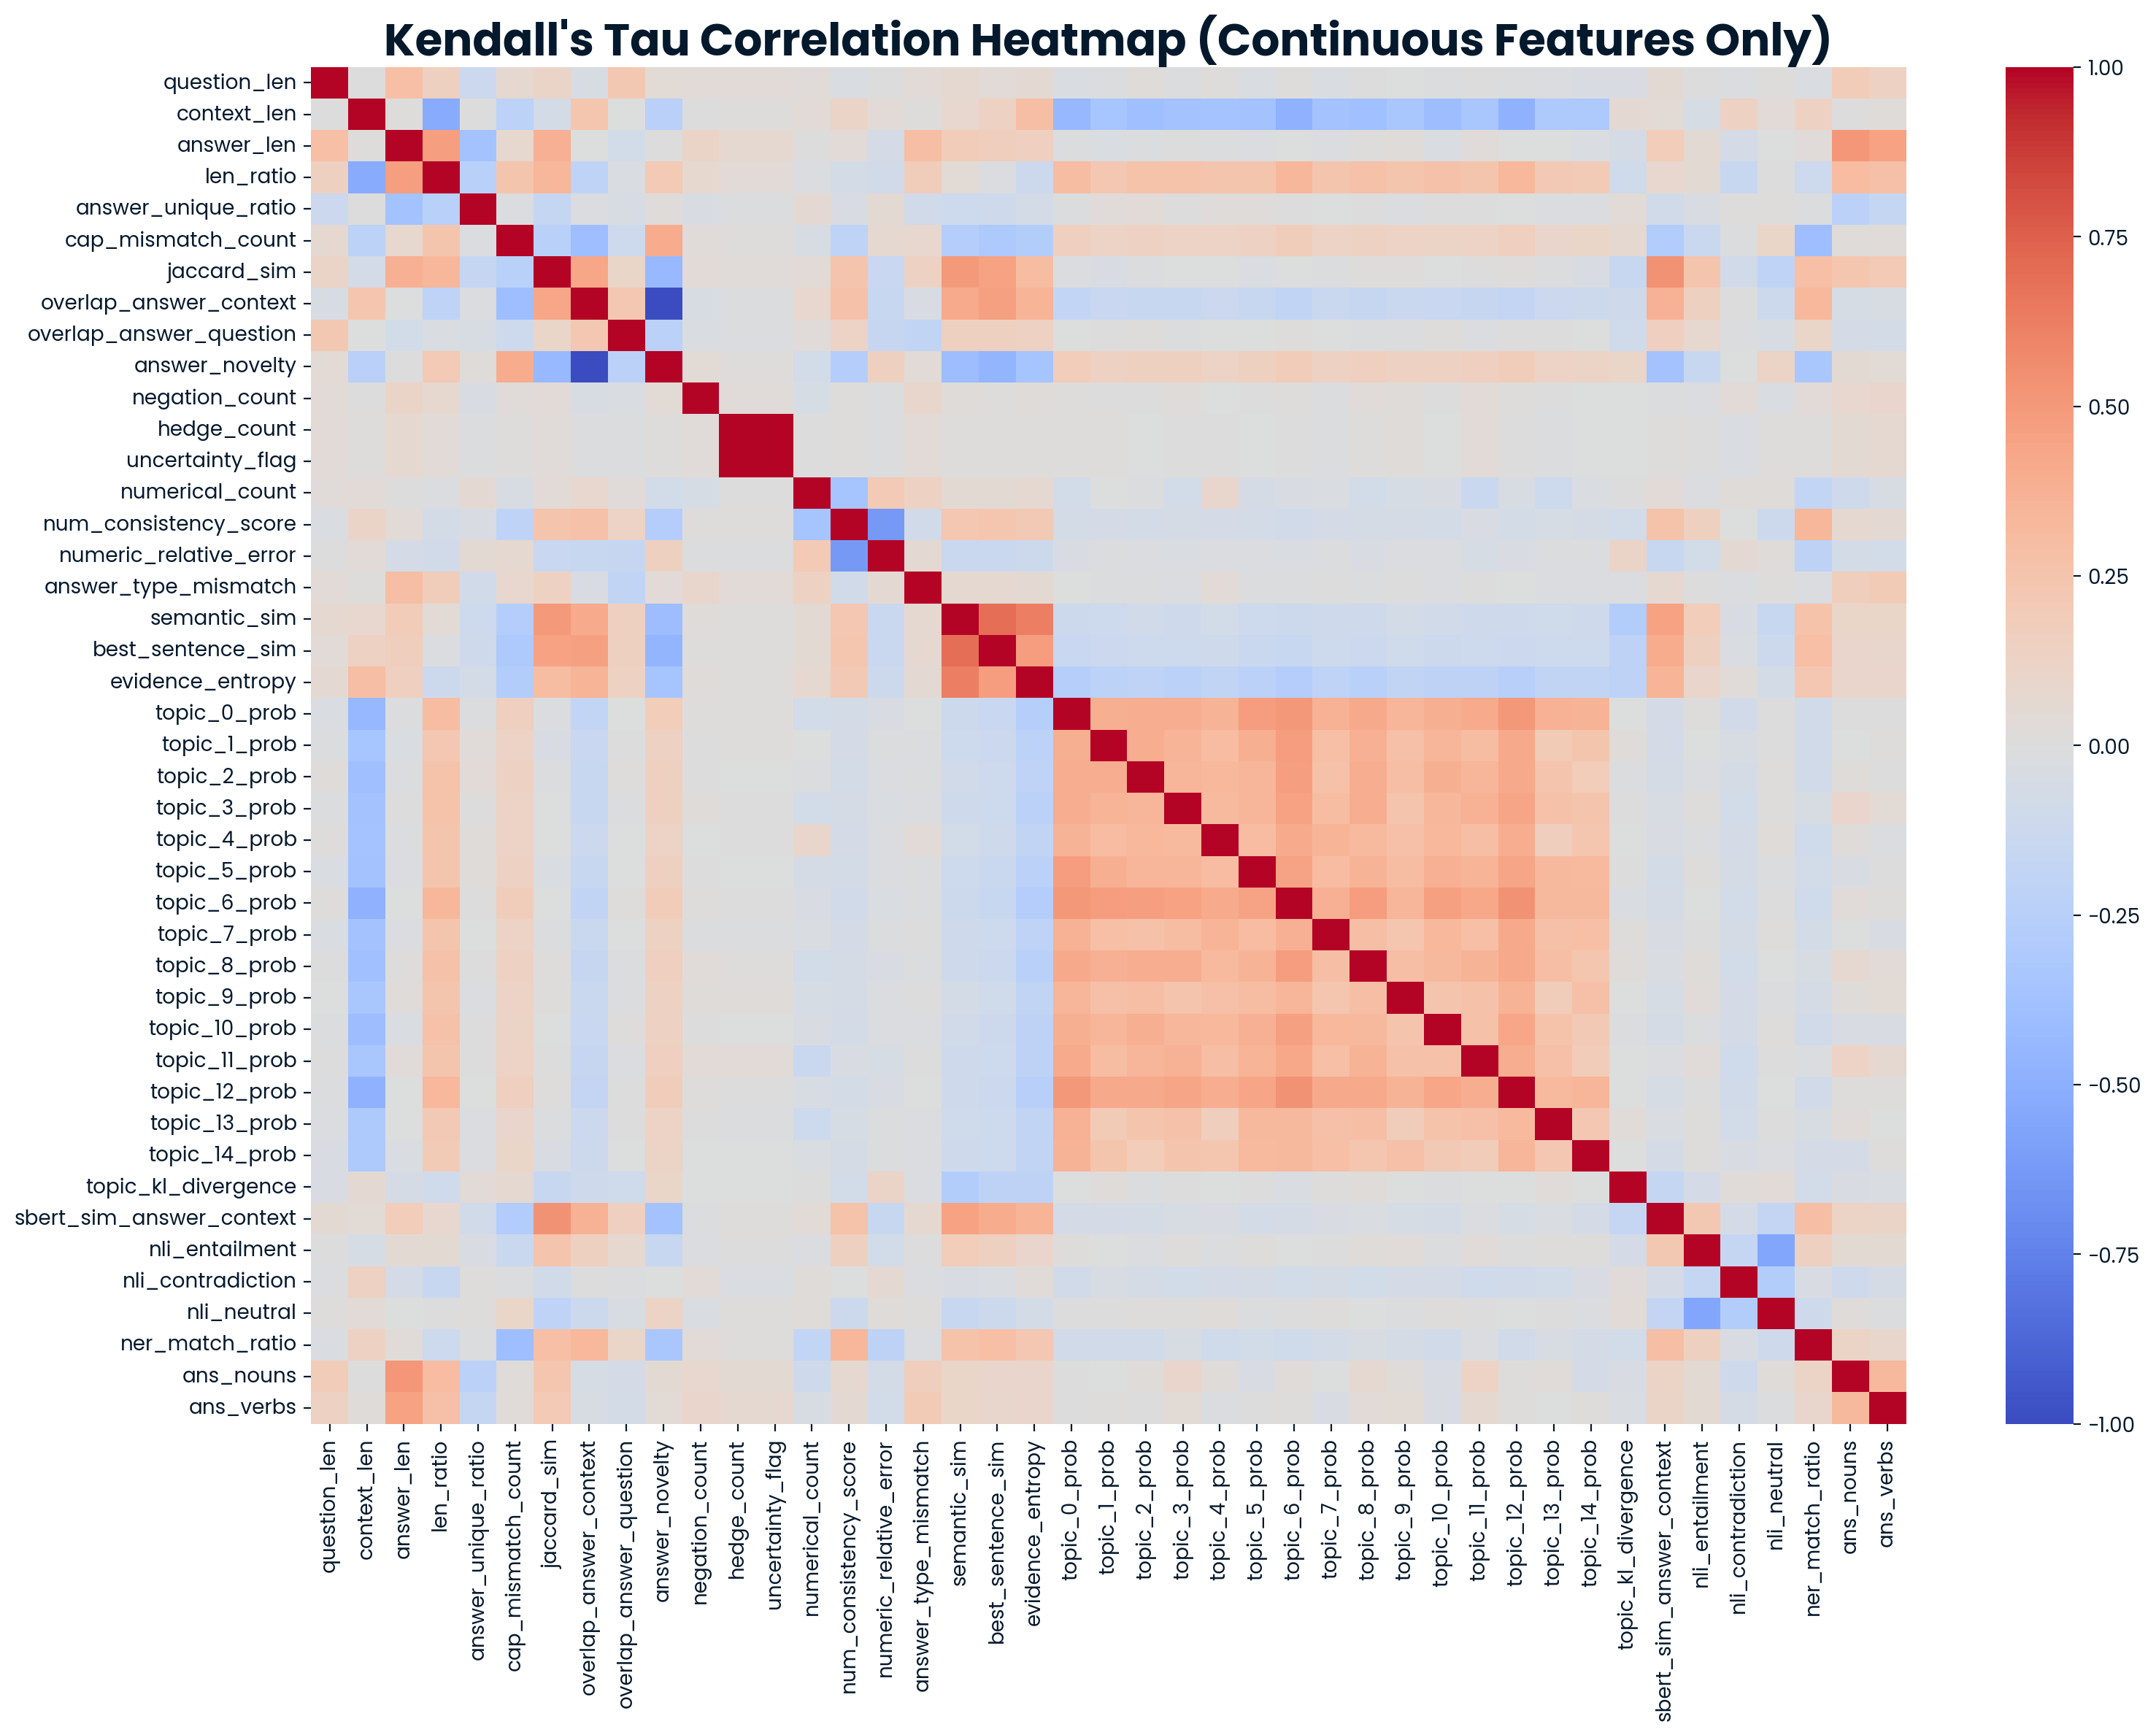

In [10]:
# Preprocessing
df_proc = train_df.copy()
for col in CATEGORICAL:
    df_proc[col] = df_proc[col].astype("category").cat.codes
X = df_proc[FINAL_FEATURES]
y = df_proc[TARGET]
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Correlation Heatmap using Kendall's tau (continuous features only, no categorical features)
continuous_features = [col for col in X_train_full.columns if col not in CATEGORICAL]
corr_matrix = X_train_full[continuous_features].corr(method='kendall')
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Kendall's Tau Correlation Heatmap (Continuous Features Only)", fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

The **Kendall’s Tau Correlation Heatmap** identifies how features move in relation to one another, providing a clear map of redundancy and feature interaction. The key insights are the following:
- **Semantic Cohesion:** strong positive cluster exists between `sbert_sim_answer_context`, `semantic_sim`, and `best_sentence_sim`. These features capture consistent semantic signals across different embedding methods.
- **Topic Clusters:** The block of `topic_0_prob` through `topic_14_prob` shows moderate positive correlation, suggesting documents often share overlapping themes, likely driven by the negative correlation with the lenghts features.
- **Low Redundancy:** Most features are only weakly correlated, which confirms the model is utilizing unique, non-redundant signals for its predictions.

The heatmap confirms that engineered features are capturing distinct lexical versus semantic information due the absence of extreme multicollinearity ($>0.9$). 

Overall **I group the features into 5 groups** that are added sequentially to model training later: **lexical, logical, evidence-based, topics, and deep learning features.**

# Predictive Modeling
My goal is to create a powerful **ensemble** using 5 base learners (boosting model, Gaussian Naive Bayes, linear SVM, Random Forest, regularized Softmax regression) while **taking the class imbalance into consideration via cost-sensitive learning**.

In the following, I first **optimize the base-learners according to the macro-F1 score using 5-fold stratified cross validation and random search for hyperparameter tuning**. Subsequently, I combine the base learners using an **MLP meta-learner** to create a **stacking ensemble**.

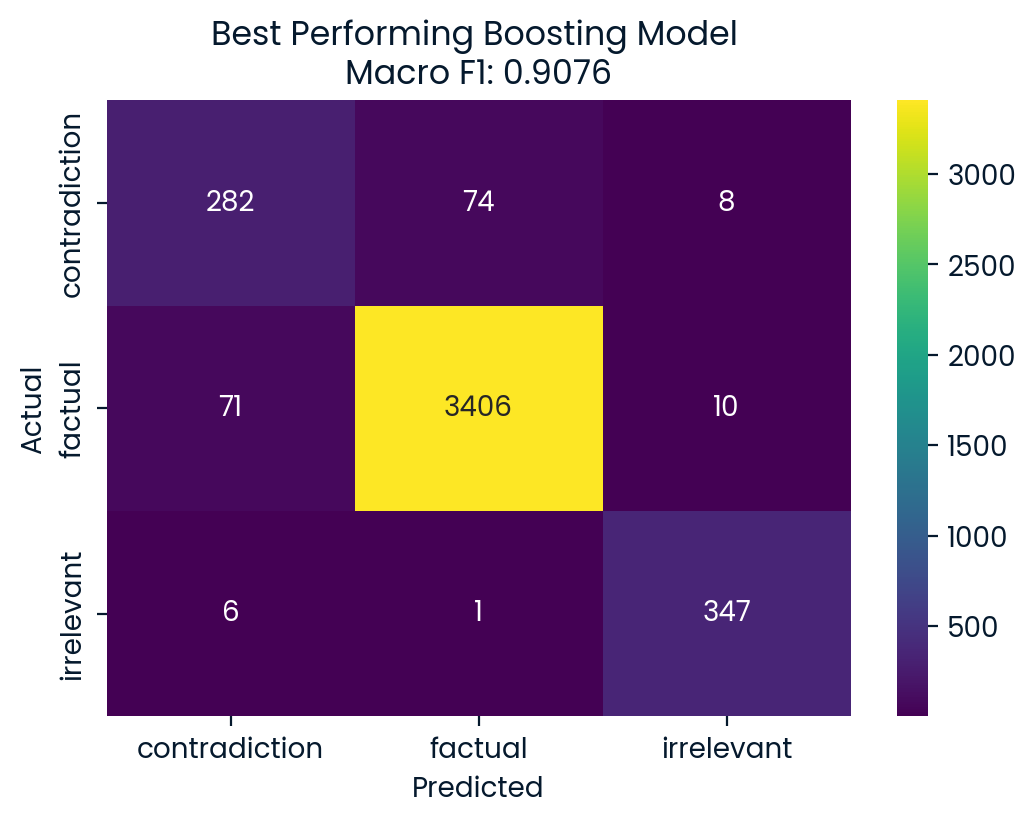

### Feature Ablation Study: Boosting Model

In [11]:
# Define function to run evaluation
def run_comprehensive_study(base_model, model_prefix="model", cmap="Greens", display_name=None):
    unique_labels = sorted(y_test.unique())
    results_list = []
    
    for set_name, features in FEATURE_SETS.items():
        # Subset split data for nested models
        X_tr_sub = X_train_full[features]
        X_te_sub = X_test_full[features]
        
        # Clone fresh model
        model = clone(base_model)
        clf = model.named_steps['classifier'] if hasattr(model, 'named_steps') else model
        
        # Update categorical indices based on current subset
        if hasattr(clf, 'categorical_features'):
            current_cat_indices = [i for i, col in enumerate(features) if col in CATEGORICAL]
            if hasattr(model, 'named_steps'):
                model.set_params(classifier__categorical_features=current_cat_indices)
            else:
                model.set_params(categorical_features=current_cat_indices)
        
        # Fit and predict
        model.fit(X_tr_sub, y_train)
        y_pred = model.predict(X_te_sub)
        
        # Compute F1-score
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        f1_per_class = f1_score(y_test, y_pred, average=None, labels=unique_labels)
        
        # Save model
        Path("intermediate_results").mkdir(exist_ok=True)
        sanitized_name = set_name.lower().replace(' ', '_').replace('+', 'plus')
        save_path = f"intermediate_results/{model_prefix}_{sanitized_name}.joblib"
        joblib.dump(model, save_path)
        
        # Store for table
        row = {"Feature Set": set_name, "Macro F1": macro_f1}
        for i, lbl in enumerate(unique_labels):
            row[f"F1 {str(lbl).capitalize()}"] = f1_per_class[i]
        
        row["_y_pred"] = y_pred # Temporary storage for CM
        results_list.append(row)

    # Identify best model
    best_res = max(results_list, key=lambda x: x['Macro F1'])
    
    # Confusion matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, best_res['_y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_labels, yticklabels=unique_labels, cmap="viridis")
    plt.title(f"Best Performing {display_name} \nMacro F1: {best_res['Macro F1']:.4f}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Ablation table
    ablation_df = pd.DataFrame(results_list).drop(columns=["_y_pred"])
    display(Markdown(f"### Feature Ablation Study: {display_name}"))
    styled_table = (
        ablation_df.style
        .background_gradient(subset=["Macro F1"], cmap=cmap)
        .format({col: "{:.4f}" for col in ablation_df.columns if col != "Feature Set"})
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', '#f4f4f4')]}])
    )
    display(styled_table)
    
    return ablation_df

# Define the base model
hgb_model = HistGradientBoostingClassifier(
    **BEST_HGB_PARAMS, 
    random_state=42, 
    class_weight="balanced",
    early_stopping=True
)

# Evaluate model
hgb_study_results = run_comprehensive_study(hgb_model, model_prefix="hgb", display_name="Boosting Model")

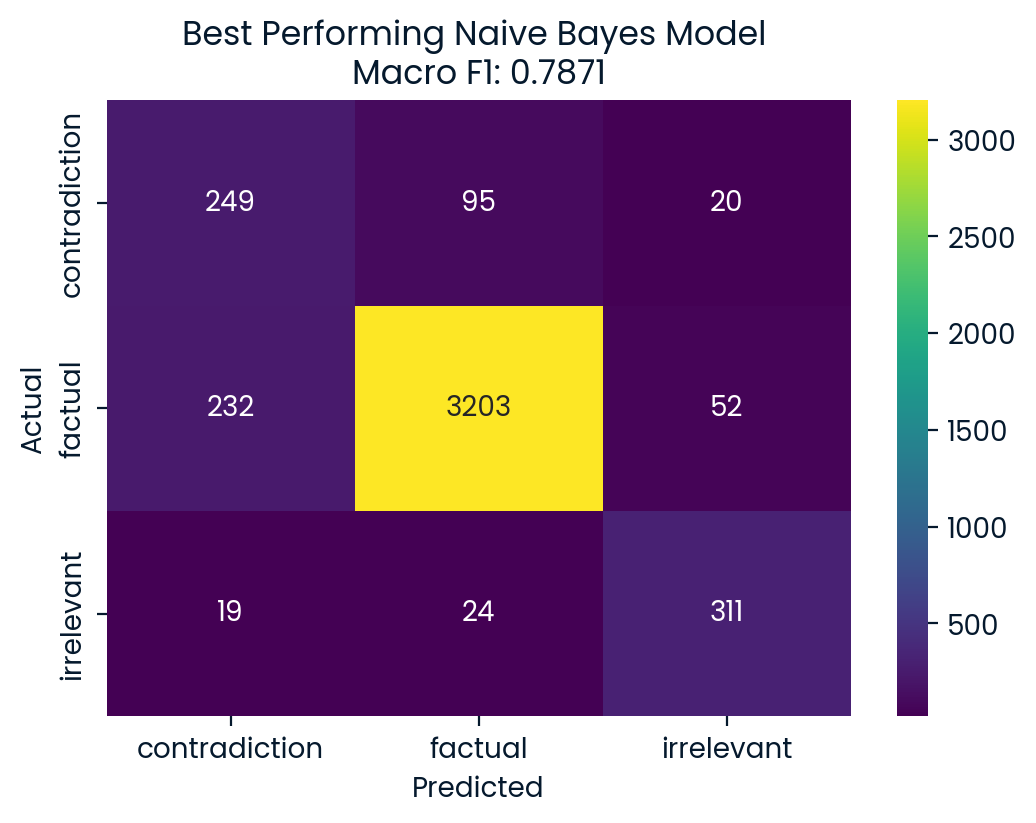

### Feature Ablation Study: Naive Bayes Model

In [12]:
# Gaussian NB
gnb_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('power_transform', PowerTransformer()),
    #('classifier', GaussianNB(priors=BEST_GNB_PRIORS, var_smoothing=BEST_GNB_SMOOTHING)) # with skeptical priors
    ('classifier', GaussianNB(var_smoothing=BEST_GNB_SMOOTHING)) # no skeptica priors
])

# Evaluate model
gnb_study_results = run_comprehensive_study(
    base_model=gnb_pipe, 
    model_prefix="gnb", 
    cmap="Oranges",
    display_name="Naive Bayes Model"
)

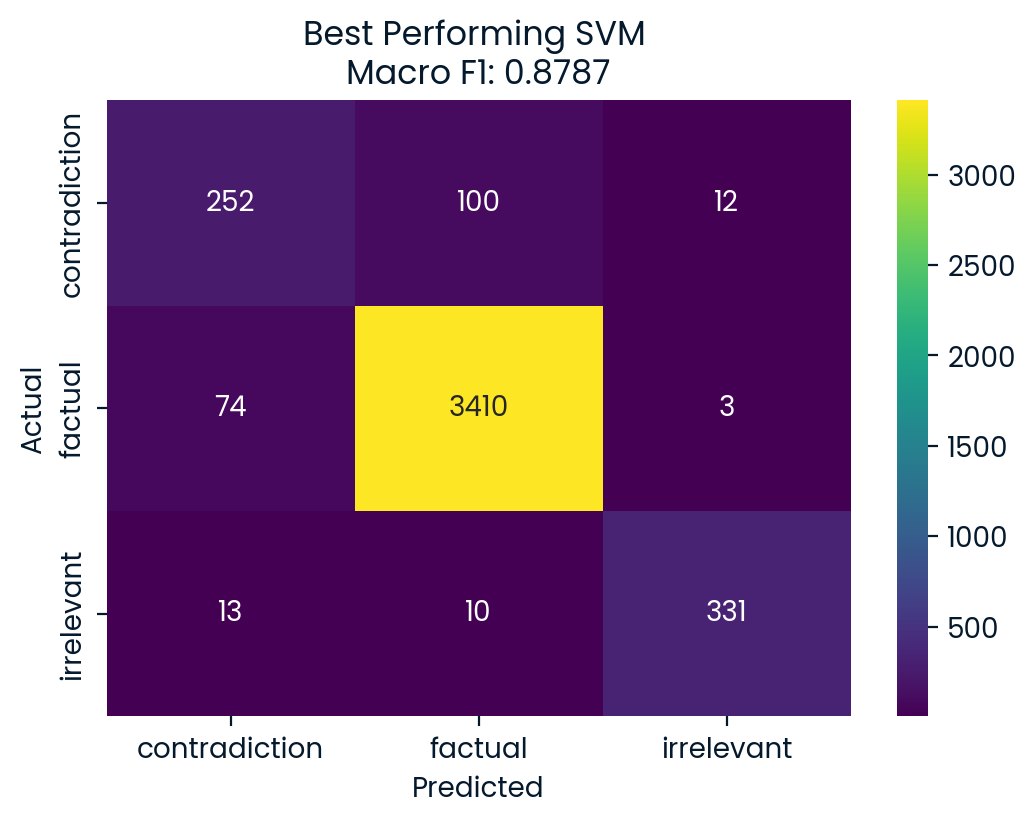

### Feature Ablation Study: SVM

In [13]:
# Define SGD (Linear SVM) model
sgd_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', SGDClassifier(
        **BEST_SGD_PARAMS,
        loss='hinge',  # to create linear SVM
        random_state=42, 
        class_weight="balanced"
    ))
])

# Evaluate model
sgd_study_results = run_comprehensive_study(sgd_pipe, model_prefix="sgd", cmap="Blues", display_name="SVM")

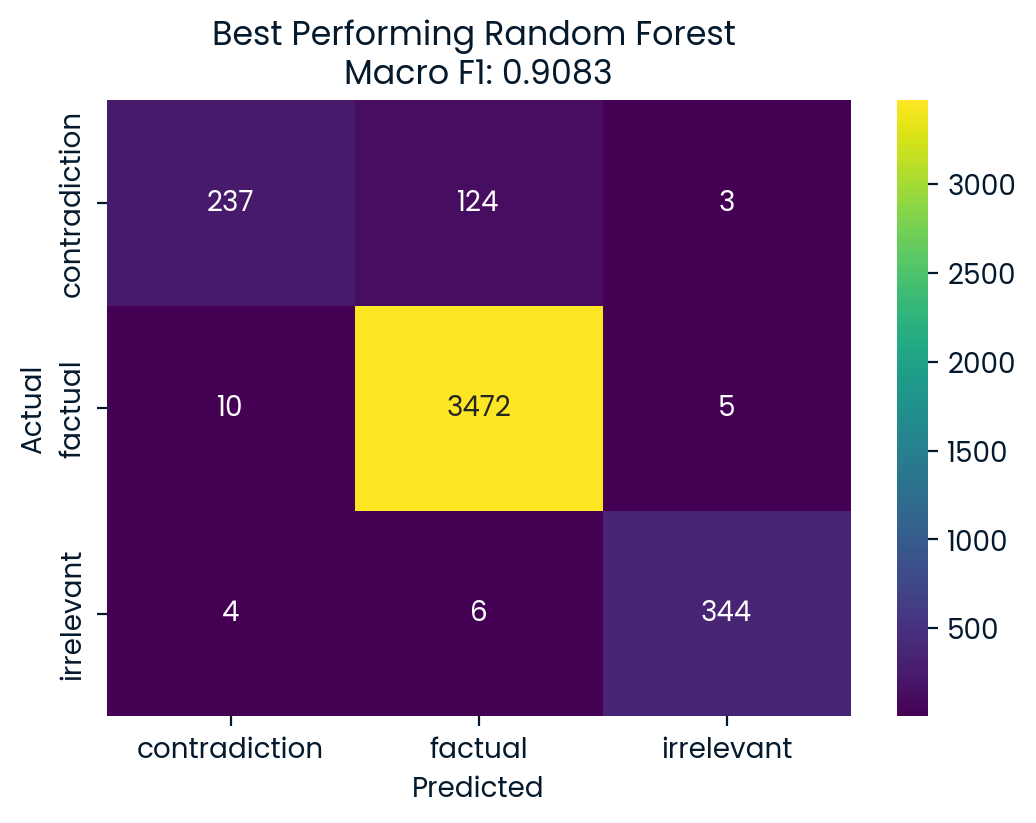

### Feature Ablation Study: Random Forest

In [14]:
# Define Random Forest Pipeline
rf_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()), 
    ('classifier', RandomForestClassifier(
        **BEST_RF_PARAMS, 
        random_state=42, 
        class_weight="balanced"
    ))
])

# Evaluate model
rf_study_results = run_comprehensive_study(rf_pipe, model_prefix="rf", cmap="Greys", display_name="Random Forest")

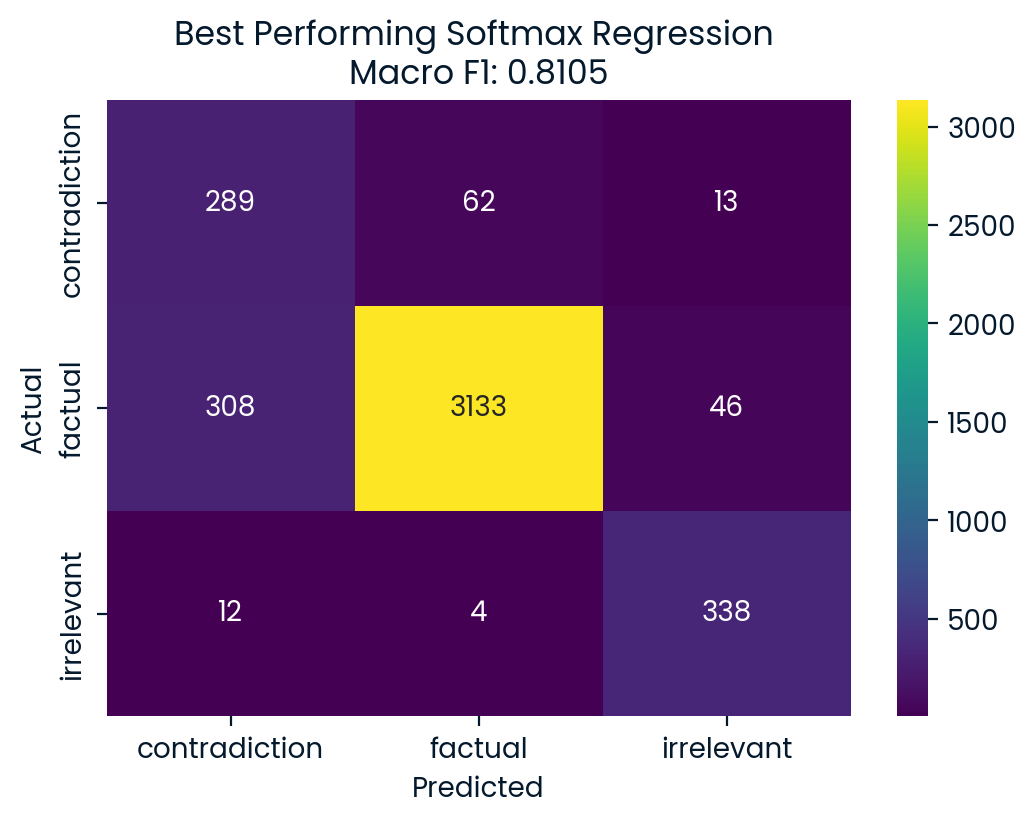

### Feature Ablation Study: Softmax Regression

In [15]:
# Define Logistic Regression Pipeline
logreg_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(**BEST_LOGREG_PARAMS)) # specified for softmax
])

# Evaluate model
lorgreg_study_results = run_comprehensive_study(logreg_pipe, model_prefix="logreg", cmap="Purples", display_name="Softmax Regression")

The base learners perform moderately to very well, with the Random Forest being the strongest measured by macro-F1 score. 

As the **features are added in groups** (to the model optimized on all features with the best hyperparameter configuration) one can assess their **individual contribution** to the performance increase stratified on the type: It becomes evident that the lexical features alone are quite predictive, yet what helps distinguish all models between predicting 'factual' vs. 'irrelevant' as `type` labels are the logical features. Topics do not seem of high relevance for predictive performance, while the deep learning features give the base learners a little boost on top at the end.

Although **cost-sensitive learning** was used to take care of class imbalances, the **performance is still lacking for the minority classes 'contradiction' and 'irrelevant'**, with the former one being far off from adequate. Yet, as differnt models make different mistakes, an ensemble - consisting of each base learner's best performing model specification - might boost especially the performance for this class.

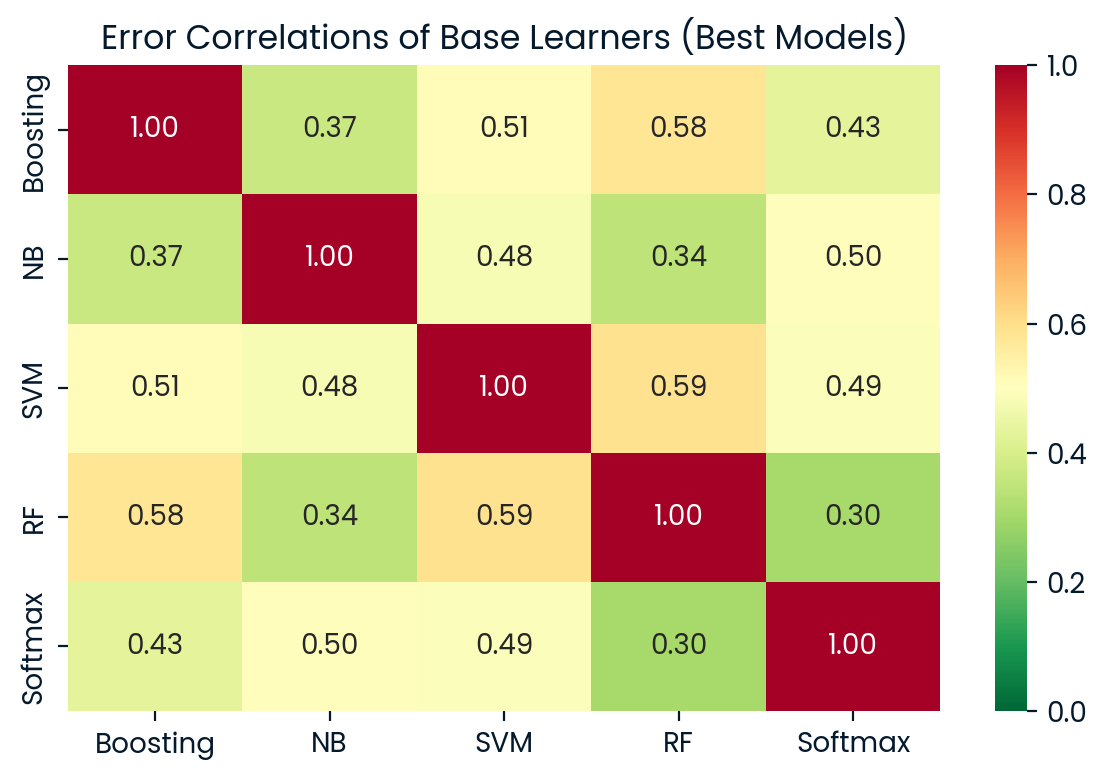

In [16]:
preds = {}

# Load and Predict
for name, path in LOAD_MAP.items():
    model = joblib.load(path)
    feat_key = "Lexical + Logic" if name == "NB" else "Full Model (+Deep Learning)"
    feats = FEATURE_SETS[feat_key]
    preds[name] = model.predict(X_test_full[feats])

# Create error dataframe (1 if wrong, 0 if correct)
pred_df = pd.DataFrame(preds, index=y_test.index)
error_df = pred_df.apply(lambda col: (col != y_test).astype(int))

# Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(
    error_df.corr(),
    annot=True,
    fmt=".2f",
    cmap="RdYlGn_r",
    vmin=0,
    vmax=1
)
plt.title("Error Correlations of Base Learners (Best Models)")
plt.tight_layout()
plt.show()

The analysis concludes that the base learners errors are mostly **only moderately correlated**, which is good for ensembling as it **increases variance**. Unsurprisingly - and likely due to their similarity - the Random Forest and boosting model are most strongly correlated. 

Therefore, I now **create a stacking ensemble using all base learners and comining them via a shallow MLP meta-learner**.

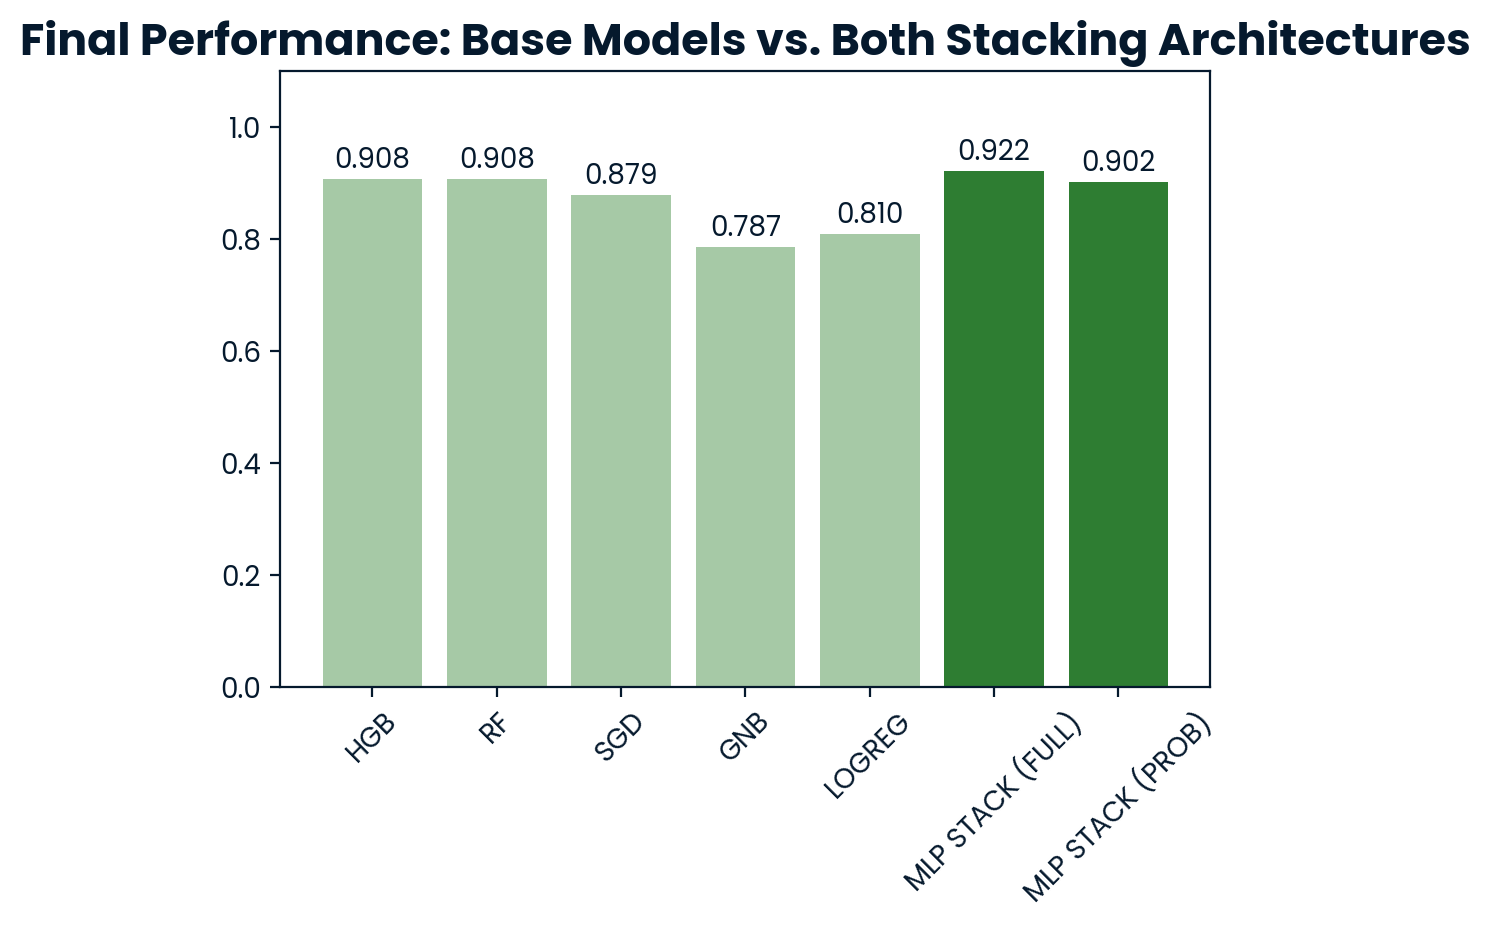

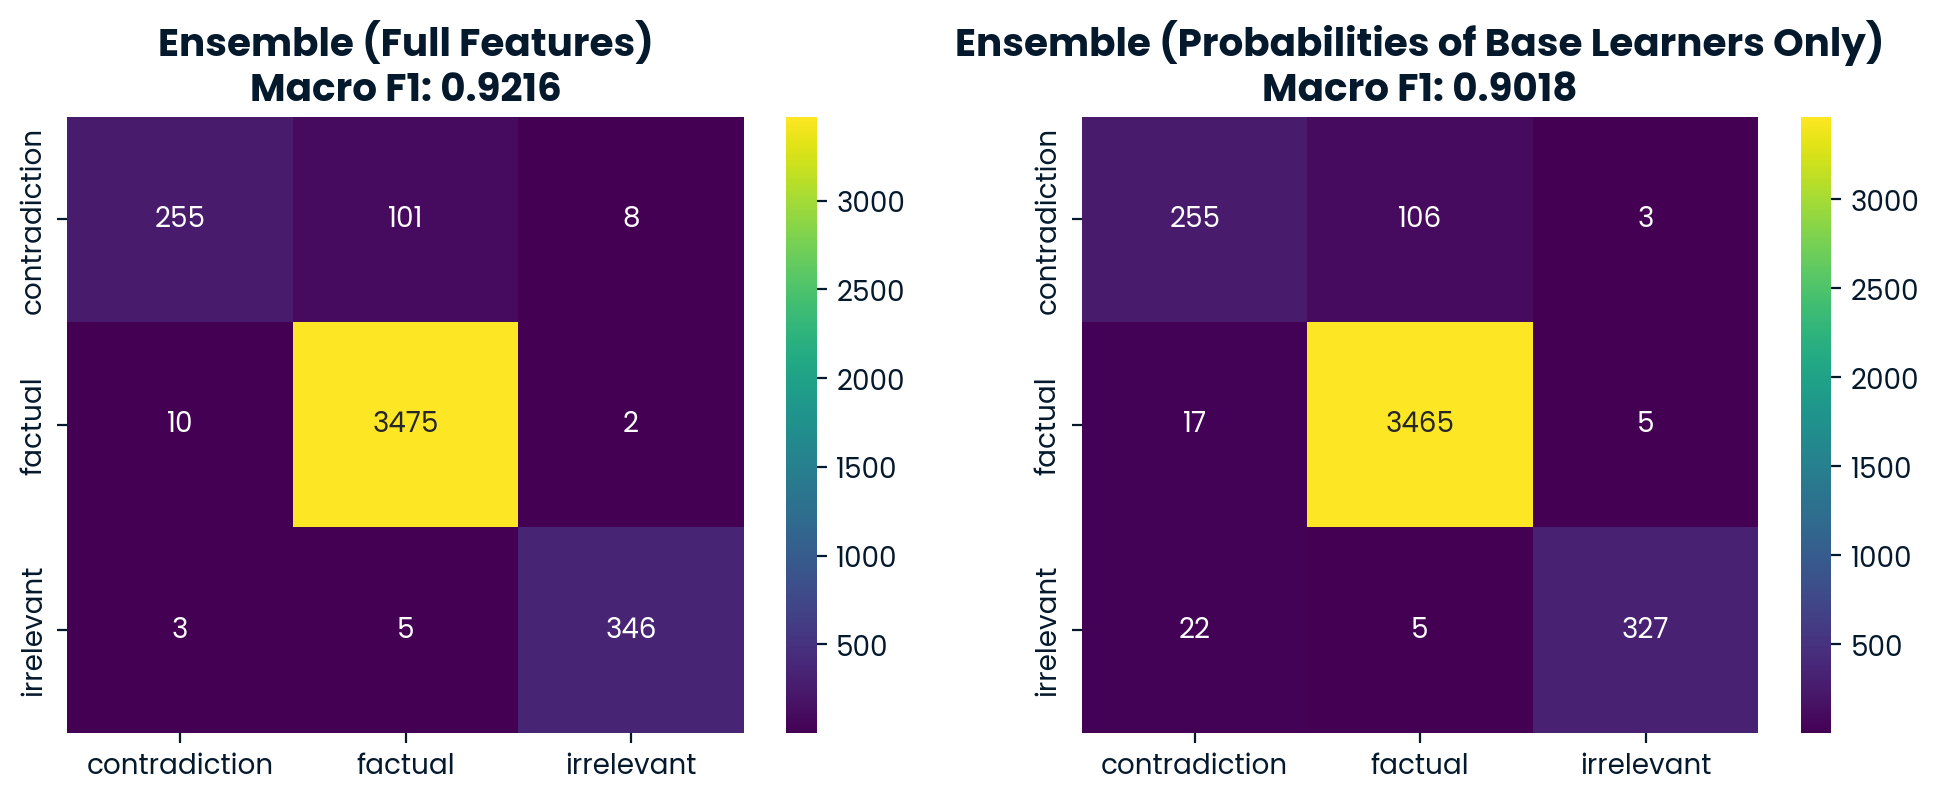

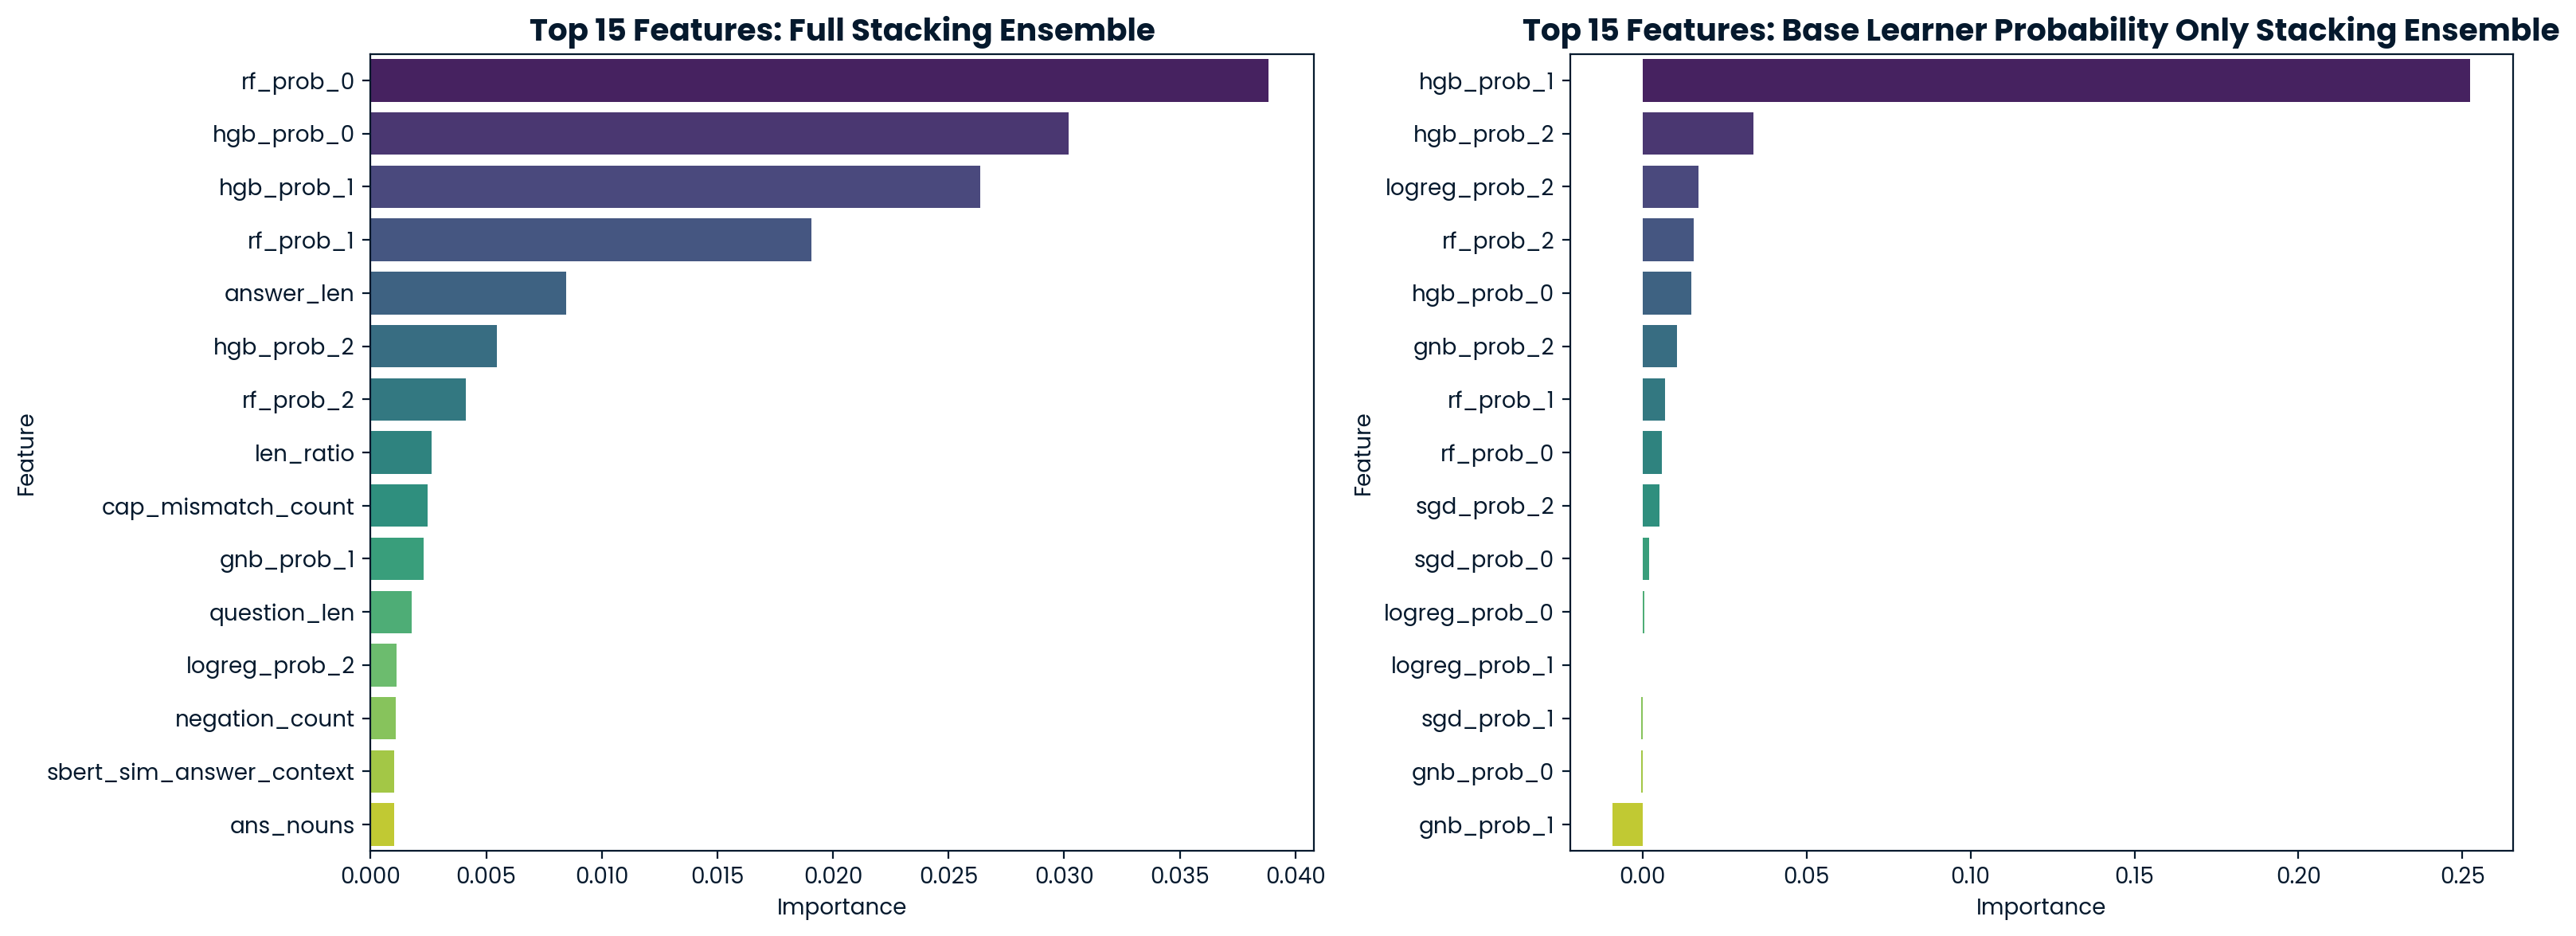

['intermediate_results/label_encoder.joblib']

In [17]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
unique_labels = np.arange(len(le.classes_))

# Prepare meta-feature dataframes
X_meta_train = X_train_full.copy()
X_meta_test = X_test_full.copy()

# Create meta features from base learners
prob_cols_only = []

for name, path in LOAD_MAP2.items():
    model = joblib.load(path)
    feats = NB_FEATURES if name == "gnb" else FULL_FEATURES
    if hasattr(model, "predict_proba"):
        probas_train = model.predict_proba(X_train_full[feats])
        probas_test = model.predict_proba(X_test_full[feats])
    else:
        preds_train = model.predict(X_train_full[feats])
        probas_train = np.eye(len(le.classes_))[le.transform(preds_train)]
        preds_test = model.predict(X_test_full[feats])
        probas_test = np.eye(len(le.classes_))[le.transform(preds_test)]
    current_prob_cols = [f"{name}_prob_{i}" for i in range(probas_train.shape[1])]
    X_meta_train[current_prob_cols] = probas_train
    X_meta_test[current_prob_cols] = probas_test
    prob_cols_only.extend(current_prob_cols)

# Train first ensemble (all features)
mlp_full = MLPClassifier(
    hidden_layer_sizes=(124, 62), alpha=0.05, activation='relu',
    solver='adam', learning_rate='adaptive', max_iter=150,
    early_stopping=True, n_iter_no_change=10, random_state=42
)
mlp_full.fit(X_meta_train, y_train_enc)
y_pred_stack_full = mlp_full.predict(X_meta_test)
f1_stack_full = f1_score(y_test_enc, y_pred_stack_full, average='macro')

# Train second ensemble (only base learners)
mlp_probs = MLPClassifier(
    hidden_layer_sizes=(10, 5), alpha=5, activation='relu',
    solver='adam', learning_rate='adaptive', max_iter=100,
    early_stopping=True, n_iter_no_change=5, random_state=42
)
mlp_probs.fit(X_meta_train[prob_cols_only], y_train_enc)
y_pred_stack_probs = mlp_probs.predict(X_meta_test[prob_cols_only])
f1_stack_probs = f1_score(y_test_enc, y_pred_stack_probs, average='macro')

# Performance comparison
results = []
for name, path in LOAD_MAP2.items():
    model = joblib.load(path)
    feats = NB_FEATURES if name == "gnb" else FULL_FEATURES
    y_pred_base = model.predict(X_test_full[feats])
    results.append((name.upper(), f1_score(y_test, y_pred_base, average='macro')))
results.append(("MLP STACK (FULL)", f1_stack_full))
results.append(("MLP STACK (PROB)", f1_stack_probs))
names, scores = zip(*results)
plt.figure(figsize=(6,4))
colors = ['#A6C9A6' if 'STACK' not in n else '#2E7D32' for n in names]
bars = plt.bar(names, scores, color=colors)
plt.ylim(0, 1.1)
plt.title('Final Performance: Base Models vs. Both Stacking Architectures', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{score:.3f}', ha='center')
plt.show()

# Confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Full stacking ensemble
cm_full = confusion_matrix(y_test_enc, y_pred_stack_full)
sns.heatmap(cm_full, annot=True, fmt='d', cmap='viridis', ax=axes[0],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[0].set_title(f'Ensemble (Full Features)\nMacro F1: {f1_stack_full:.4f}', fontsize=14, fontweight='bold')

# Stacking ensemble only with base learner features
cm_probs = confusion_matrix(y_test_enc, y_pred_stack_probs)
sns.heatmap(cm_probs, annot=True, fmt='d', cmap='viridis', ax=axes[1],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[1].set_title(f'Ensemble (Probabilities of Base Learners Only)\nMacro F1: {f1_stack_probs:.4f}', fontsize=14, fontweight='bold')
plt.show()

# Feature Importance
r_full = permutation_importance(mlp_full, X_meta_test, y_test_enc, 
                                n_repeats=5, random_state=42, n_jobs=-1, scoring='f1_macro')
fi_full = pd.DataFrame({'Feature': X_meta_test.columns, 'Importance': r_full.importances_mean}).sort_values(by='Importance', ascending=False)
r_probs = permutation_importance(mlp_probs, X_meta_test[prob_cols_only], y_test_enc, 
                                 n_repeats=5, random_state=42, n_jobs=-1, scoring='f1_macro')
fi_probs = pd.DataFrame({'Feature': prob_cols_only, 'Importance': r_probs.importances_mean}).sort_values(by='Importance', ascending=False)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(data=fi_full.head(15), x='Importance', y='Feature', palette='viridis', ax=axes[0])
axes[0].set_title('Top 15 Features: Full Stacking Ensemble', fontsize=14, fontweight='bold')
sns.barplot(data=fi_probs.head(15), x='Importance', y='Feature', palette='viridis', ax=axes[1])
axes[1].set_title('Top 15 Features: Base Learner Probability Only Stacking Ensemble', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Save models
joblib.dump(mlp_full, 'intermediate_results/stacking_ensemble_full.joblib')
joblib.dump(mlp_probs, 'intermediate_results/stacking_ensemble_probs_only.joblib')
joblib.dump(le, 'intermediate_results/label_encoder.joblib')

The **stacking ensemble does not meaningfully enhance model performance**, yet it arguably **adds robustness** to the predictions and increases the macro-F1 score slightly. 

The **extracted meta-features are of high feature importance** (as computed via permutations for the first ensemble), similar meta features also rank well for the solely meta-feature based MLP. To **avoid costly neural architecture search, the heuristic of choosing 2 hidden layers with twice the size of inputs (first layer) and the same size as inputs (second layers) was used**. Overall, the model still struggles to distinguish between actual 'contradiction'-type answers, often times misclassifying them as 'factual', yet the overall performance is quite good.

For the final predictions, I use the **best performing model**: the **stacking ensemble trained on all features incl. meta features**.

# Predict on Test Data & Finalize Predictive Modeling
Predict the 'type' target on the test data and save to test.json again for submission

In [18]:
# Load test data, stacking ensemble, and label encoder
df_test = pd.read_json("intermediate_results/df_test.json")
test_data = pd.read_json("data/test.json")
stacking_ensemble = joblib.load("intermediate_results/stacking_ensemble_full.joblib")
le = joblib.load("intermediate_results/label_encoder.joblib")  # old encoder

# Configuration for feature reconstruction
LOAD_MAP = {
    "hgb": "intermediate_results/hgb_full_model_(plusdeep_learning).joblib",
    "rf": "intermediate_results/rf_full_model_(plusdeep_learning).joblib",
    "sgd": "intermediate_results/sgd_full_model_(plusdeep_learning).joblib",
    "gnb": "intermediate_results/gnb_lexical_plus_logic.joblib",
    "logreg": "intermediate_results/logreg_full_model_(plusdeep_learning).joblib"
}

NB_FEATURES = FEAT_LEXICAL + FEAT_LOGIC + CATEGORICAL
FULL_FEATURES = FINAL_FEATURES

# Ensure categorical columns are encoded the same way as training
train_df = pd.read_json("intermediate_results/df_train.json")
df_test_proc = df_test.copy()
for col in CATEGORICAL:
    df_test_proc[col] = pd.Categorical(df_test_proc[col], categories=train_df[col].astype("category").cat.categories)
    df_test_proc[col] = df_test_proc[col].cat.codes

# Base features for stacking
X_test_full_new = df_test_proc[FINAL_FEATURES].copy()
X_meta_test_new = X_test_full_new.copy()
prob_cols_only = []

# Generate meta-features (predicted probabilities) for stacking ensemble
for name, path in LOAD_MAP.items():
    model = joblib.load(path)
    feats = NB_FEATURES if name == "gnb" else FULL_FEATURES

    if hasattr(model, "predict_proba"):
        probas_test = model.predict_proba(X_test_full_new[feats])
    else:
        preds_test = model.predict(X_test_full_new[feats])
        probas_test = np.eye(len(le.classes_))[le.transform(preds_test)]

    current_prob_cols = [f"{name}_prob_{i}" for i in range(probas_test.shape[1])]
    X_meta_test_new[current_prob_cols] = probas_test
    prob_cols_only.extend(current_prob_cols)

# Predict using the stacking ensemble
y_preds = stacking_ensemble.predict(X_meta_test_new)
df_test["preds"] = y_preds

# Decode predictions to original labels
df_test["preds"] = le.inverse_transform(df_test["preds"])

# Merge predictions into the original test dataset
test_data = test_data.merge(
    df_test[["ID", "preds"]],
    on="ID",
    how="left"
)
test_data["type"] = test_data["preds"]
test_data = test_data.drop(columns=["preds"])

# Save updated test data
Path("data").mkdir(exist_ok=True)
test_data.to_json("data/test.json", orient="records", lines=False)

# Explainability & Interpretability
The question remains what drives performance and how features interact. In the following I use **IML techniques** aiming to answer these questions.

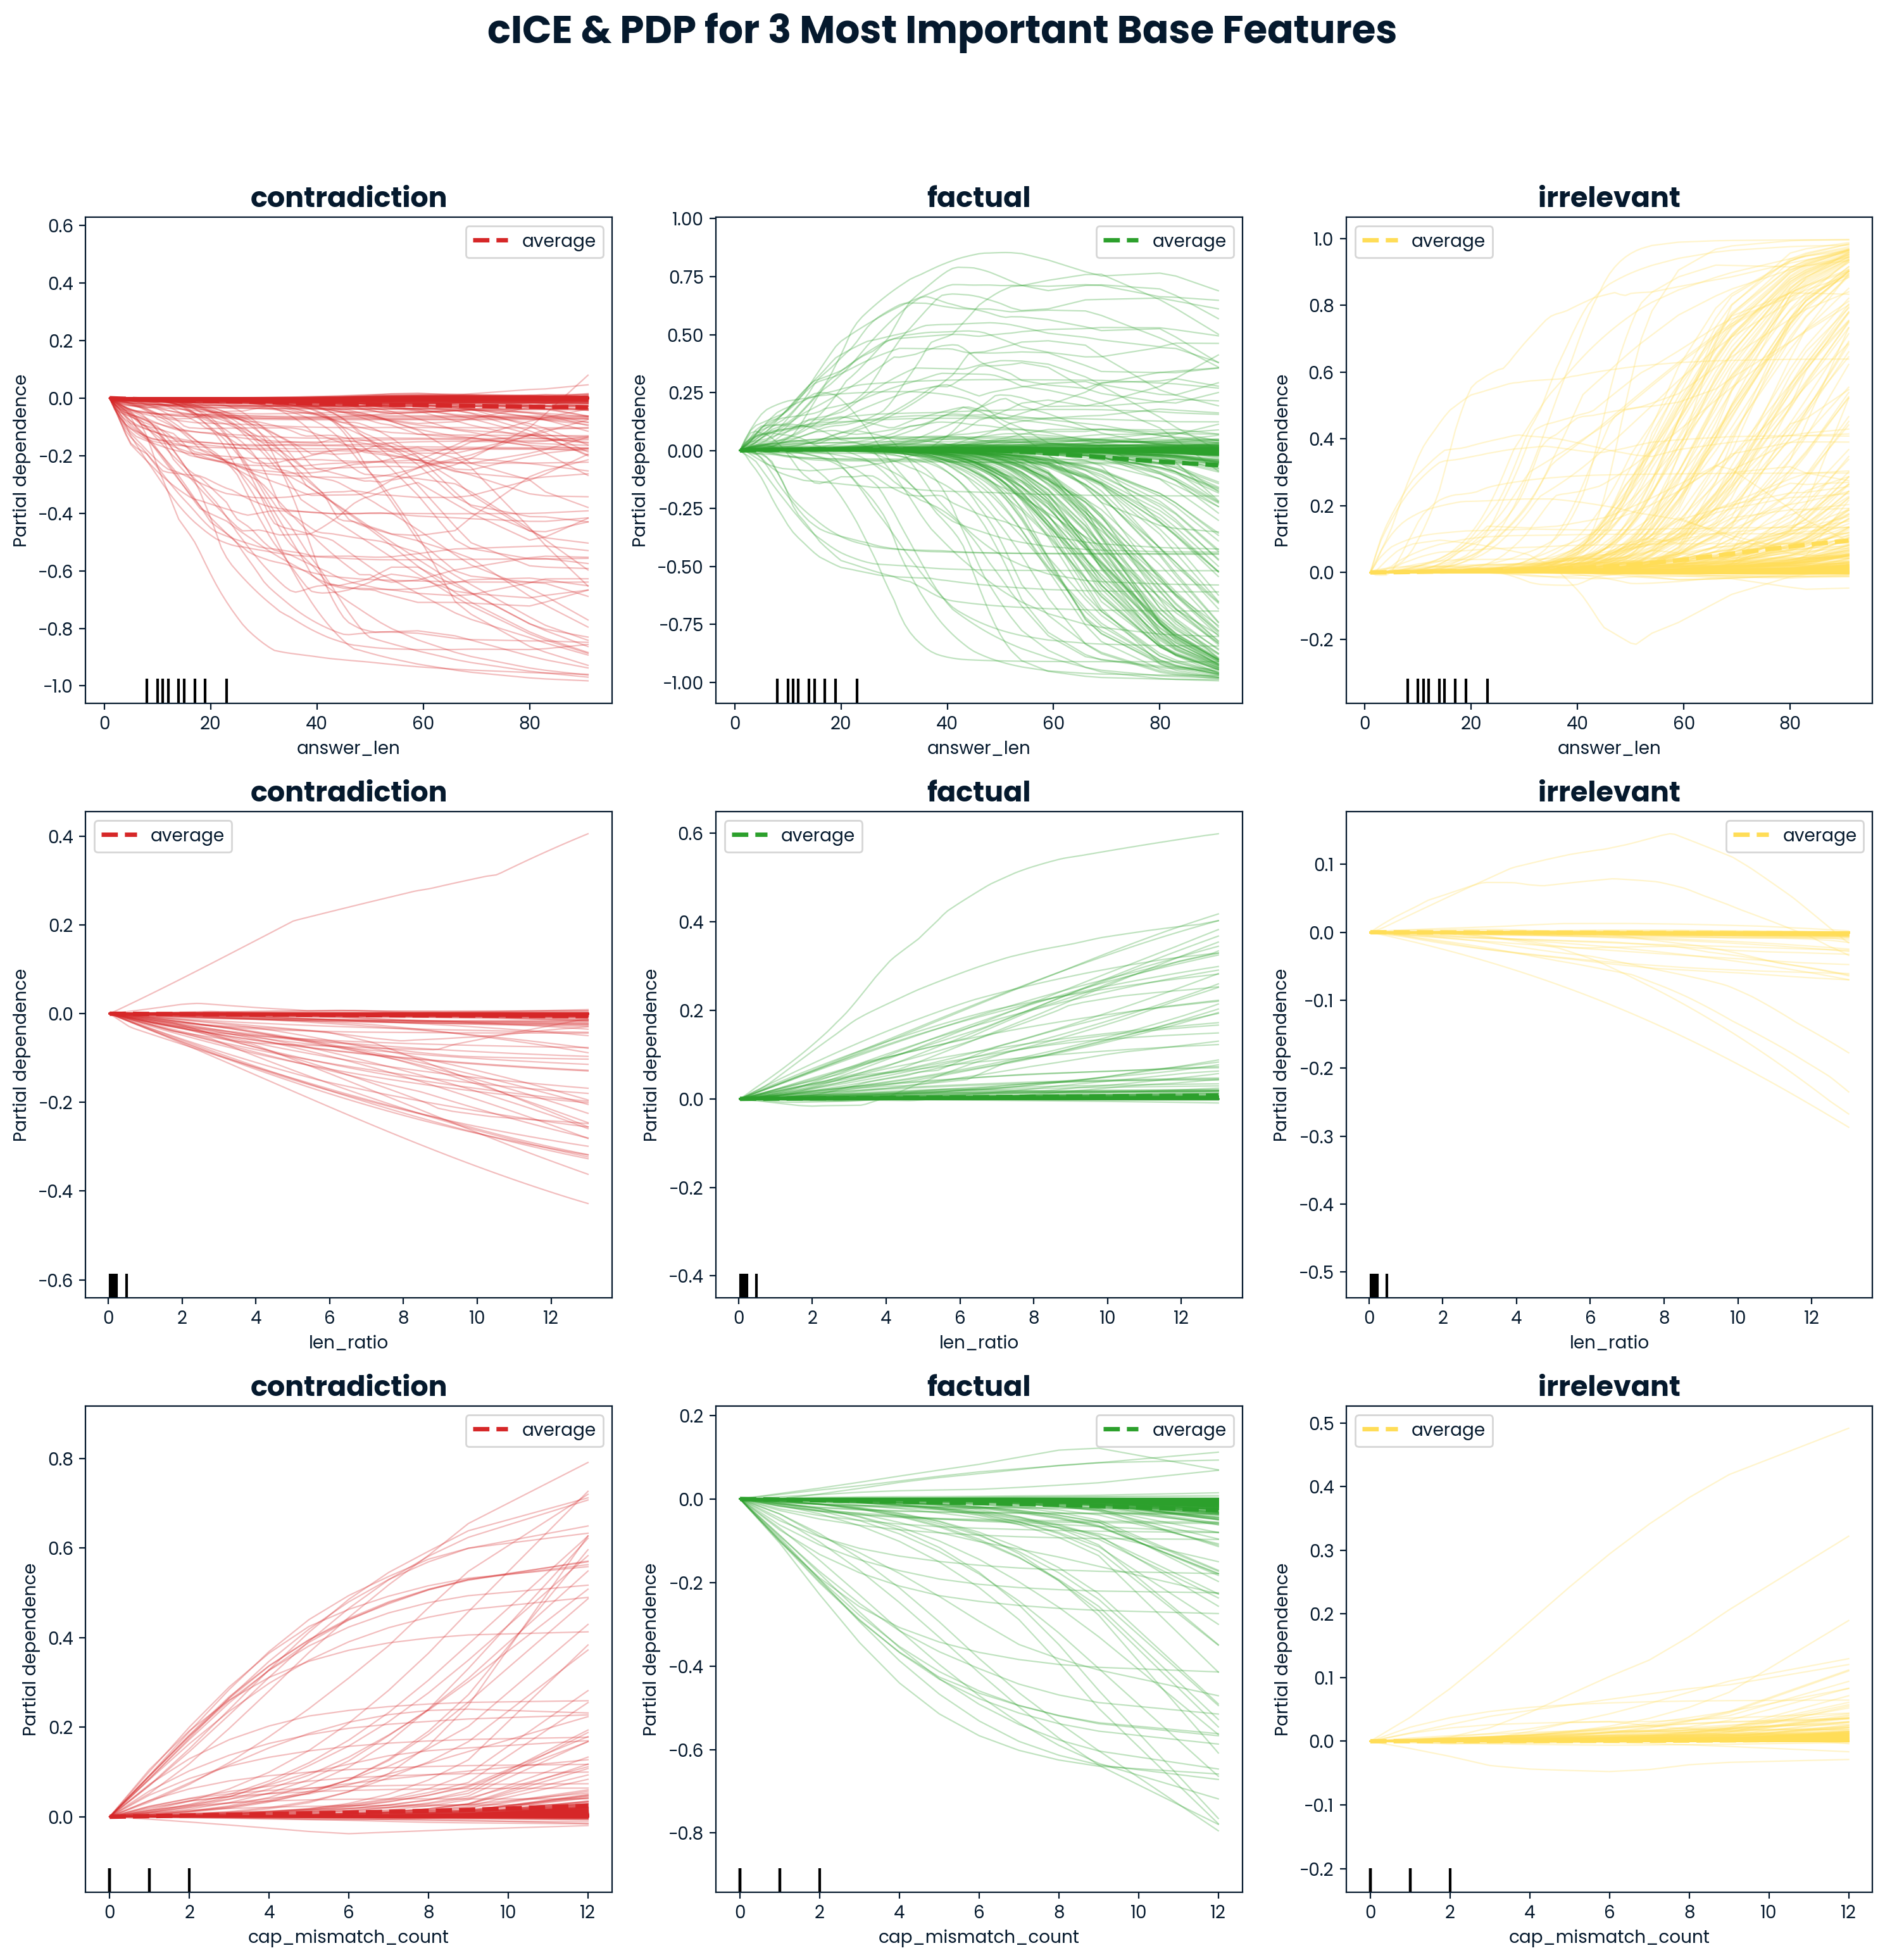

In [19]:
# ALE
def compute_ale(model,X,feat,bins=20):
    v=X[feat].values
    qs=np.unique(np.quantile(v,np.linspace(0,1,bins+1)))
    centers=[]
    effects=[]
    for a,b in zip(qs[:-1],qs[1:]):
        idx=(v>=a)&(v<b)
        if idx.sum()==0:continue
        Xl=X.loc[idx].copy()
        Xh=X.loc[idx].copy()
        Xl[feat]=a
        Xh[feat]=b
        effects.append((model.predict_proba(Xh)-model.predict_proba(Xl)).mean(axis=0))
        centers.append((a+b)/2)
    effects=np.cumsum(effects,axis=0)
    effects-=effects.mean(axis=0)
    return np.array(centers),effects

# PDP + ICE visualization of top 3 features (excluding meta features)
class_names = ['contradiction', 'factual', 'irrelevant']
traffic_lights = [TRAFFIC_LIGHTS[c] for c in class_names]
top3 = fi_full[~fi_full["Feature"].str.contains("_prob_")].head(3)["Feature"].tolist()
n_classes = len(class_names)
fig, axes = plt.subplots(len(top3), n_classes, figsize=(5 * n_classes, 5 * len(top3)))
fig.suptitle("cICE & PDP for 3 Most Important Base Features", fontsize=22, fontweight='bold', y=1.03)
for i, f in enumerate(top3):
    for j in range(n_classes):
        ax = axes[i, j] if len(top3) > 1 else axes[j]
        display_pdp = PartialDependenceDisplay.from_estimator(
            mlp_full, X_meta_test, [f], ax=ax, kind="both", centered = True, target=j,
            line_kw={'color': traffic_lights[j], 'linewidth': 2.5},
            ice_lines_kw={'color': traffic_lights[j], 'alpha': 0.3, 'linewidth': 0.8}
        )
        handles, labels = ax.get_legend_handles_labels()
        new_labels = ['PDP' if label.lower() == 'average' else label for label in labels]
        if handles:
            ax.legend(handles, new_labels)
        ax.set_title(class_names[j], fontsize=16, fontweight='bold')
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

I first analyze **how the 3 base features with the highest feature importance scores affect predictions**. I disregard the meta features for this analysis, as a prior analysis clearly and unsurprisingly showed that the probability predictions for a certain class a linearly related to its probability prediction of the meta-learner as well.

The cICE plot of `answer_len` clearly shows **non-linear effects and interactions for all three class predictions**. While a higher answer length typically means that the AI-generated answer is more likely to be irrelevant (PDP), the strength of this increase in probability depends on other factors (fanning out as seen by cICE lines). Conversely, the same holds for factual and contradiction predictions.

The plots of `len_ratio`, on the other hand, do not indicate the presence of interactions, while for `cap_mismatch_count` it is hard to tell from the plots alone.

In [20]:
explainer_path = "intermediate_results/mlp_shap_explainer.joblib"
values_path = "intermediate_results/mlp_shap_values.joblib"
os.makedirs("intermediate_results", exist_ok=True)
if os.path.exists(explainer_path) and os.path.exists(values_path):
    explainer = joblib.load(explainer_path)
    shap_values = joblib.load(values_path)
else:
    background = shap.sample(X_meta_train, 200, random_state=42)
    explainer = shap.Explainer(
        mlp_full.predict_proba, 
        background, 
        feature_names=X_meta_train.columns.tolist()
    )
    shap_values = explainer(X_meta_test)
    joblib.dump(explainer, explainer_path)
    joblib.dump(shap_values, values_path)

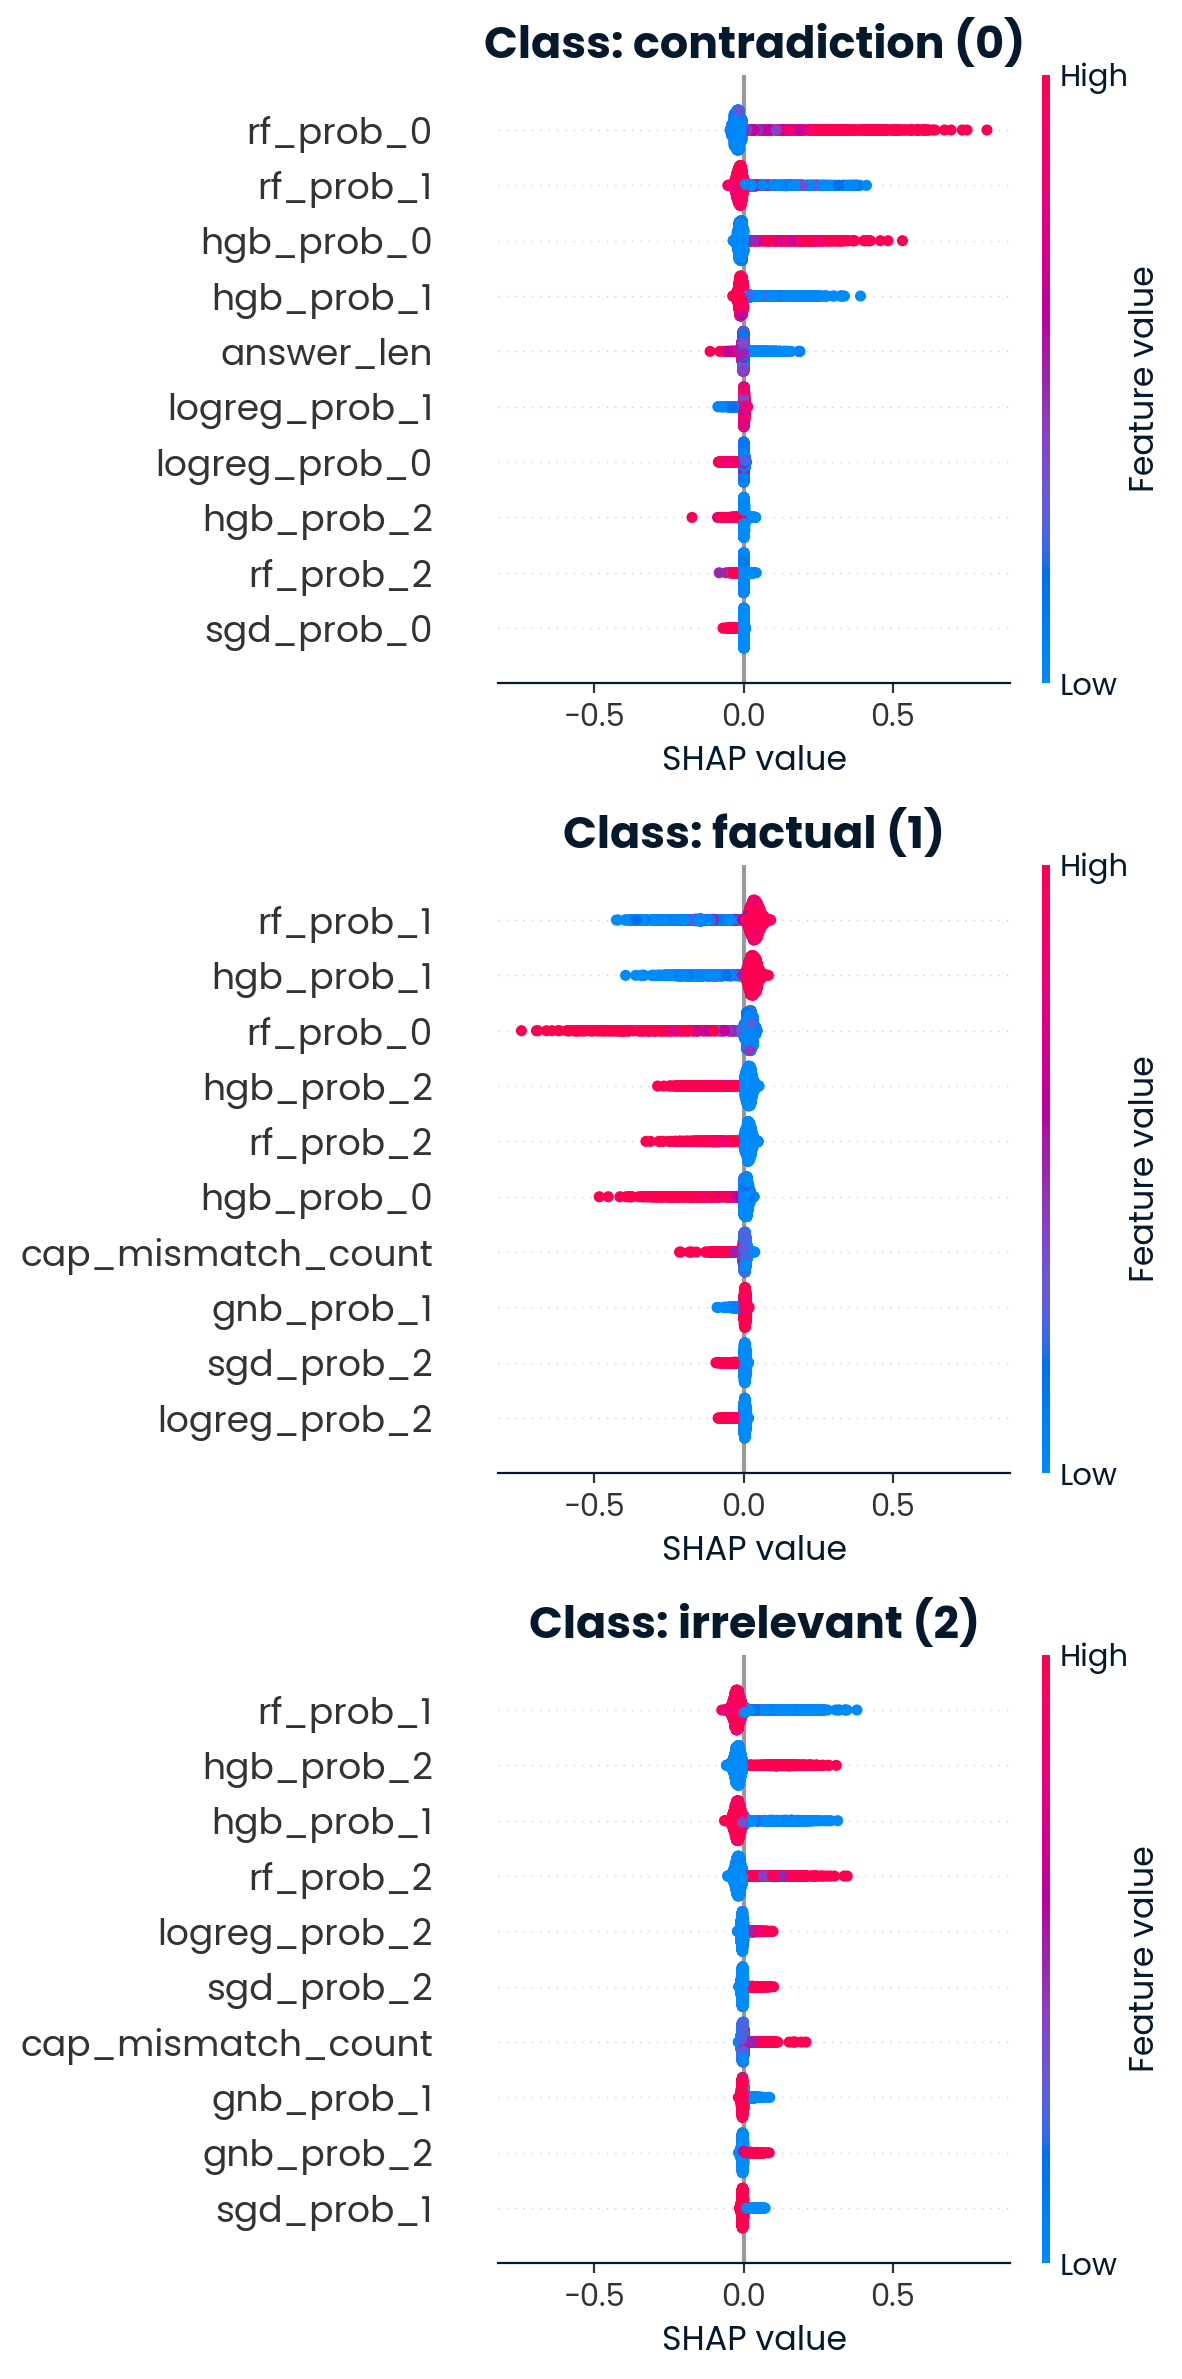

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(6, 12), sharex=True)
for i, cls in enumerate(le.classes_[:3]):
    plt.sca(axes[i])
    shap.summary_plot(
        shap_values.values[:, :, i],
        X_meta_test,
        feature_names=X_meta_test.columns,
        max_display=10,
        show=False,
        plot_size=None
    )
    axes[i].set_title(f"Class: {cls} ({i})", fontsize=16, fontweight='bold')
    axes[i].set_xlabel("SHAP value", fontsize=12)

plt.tight_layout()
plt.show()

The **top 10 SHAP values**, which are computed for each class, support the prior interpretation of the cICE and PDP plots. Yet, more is revealed: 
- Higher values of the meta-features (probabilities of classes 0, 1, and 2 or in real labels contradiction, factual, and irrelevant) are linearly and positively related to the respective probability prediction by the MLP meta-learner in case of the Random Forest and boosting model base learners - which were the most important meta features and best performing base learners
- For the contradiction class, some base learner's respective probabilities are, however, negatively related to the prediction probability (see `logreg_prob_0` and `sgd_prob_0`)
- The same base features as before exhibit high importance (`answer_len`, `cap_mismatch_count`)

This - in addition to the cICE and PDP plots - **suggests that the MLP meta-learner learned some important interactions and how to weigh base learners' probability predictions** for further performance boosting.

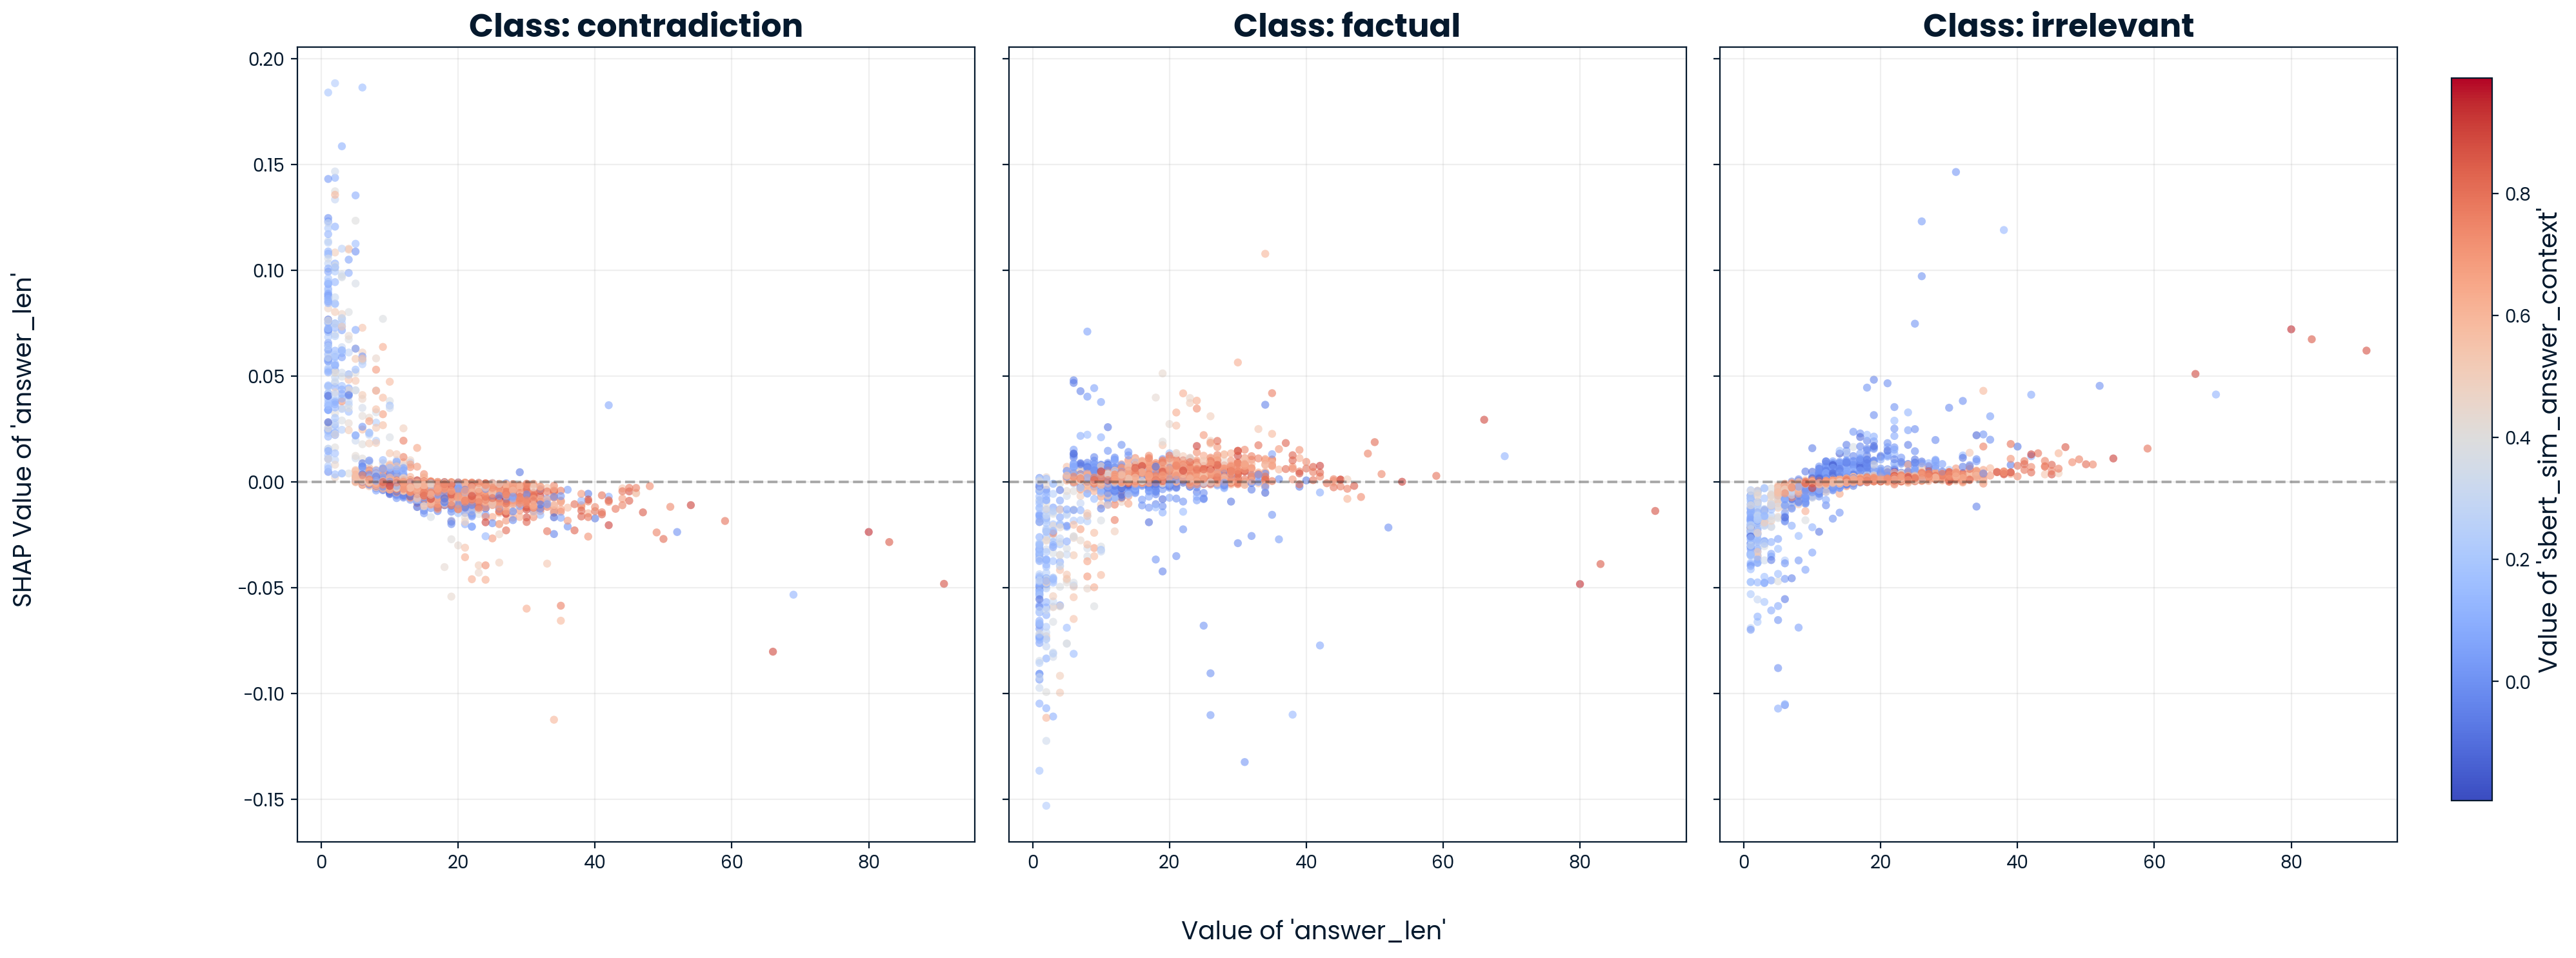

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(21, 8), sharey=True)
class_names = ["contradiction", "factual", "irrelevant"]
color_data = X_meta_test["sbert_sim_answer_context"]
norm = Normalize(vmin=color_data.min(), vmax=color_data.max())
cmap = "coolwarm" 
for i, ax in enumerate(axes):
    x_val = X_meta_test["answer_len"]
    y_shap = shap_values[:, "answer_len", i].values
    sc = ax.scatter(
        x_val, 
        y_shap, 
        c=color_data, 
        cmap=cmap, 
        norm=norm, 
        alpha=0.6, 
        edgecolors='none',
        s=20
    )
    ax.set_title(f"Class: {class_names[i]}", fontsize=18, fontweight='bold')
    ax.axhline(0, color='black', linestyle='--', alpha=0.3) 
    ax.grid(True, alpha=0.2)
fig.supxlabel("Value of 'answer_len'", fontsize=14)
fig.supylabel("SHAP Value of 'answer_len'", fontsize=14)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7]) 
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label("Value of 'sbert_sim_answer_context'", fontsize=14)
plt.subplots_adjust(right=0.9, wspace=0.05)
plt.show()

These scatter plots serve as examples to visualize how logical and lexical features interact:
- **Left plot:** Generally, a short answer length indicates that the answer is more likely to be wrong and therefore the shap value is high
- **Center & right plot:** longer answers indicate that the answers are more likely to be factual or irrelevant. But how to decide?
- **Coloring:** Looking at the value of semantic similarity between answer and context, it becomes evident that this variable is used to distinguish between factual and non-factual (irrelevant and contradictions) for longer answers.

**This demonstrates the interaction effect between logical and lexical features exemplarily.**

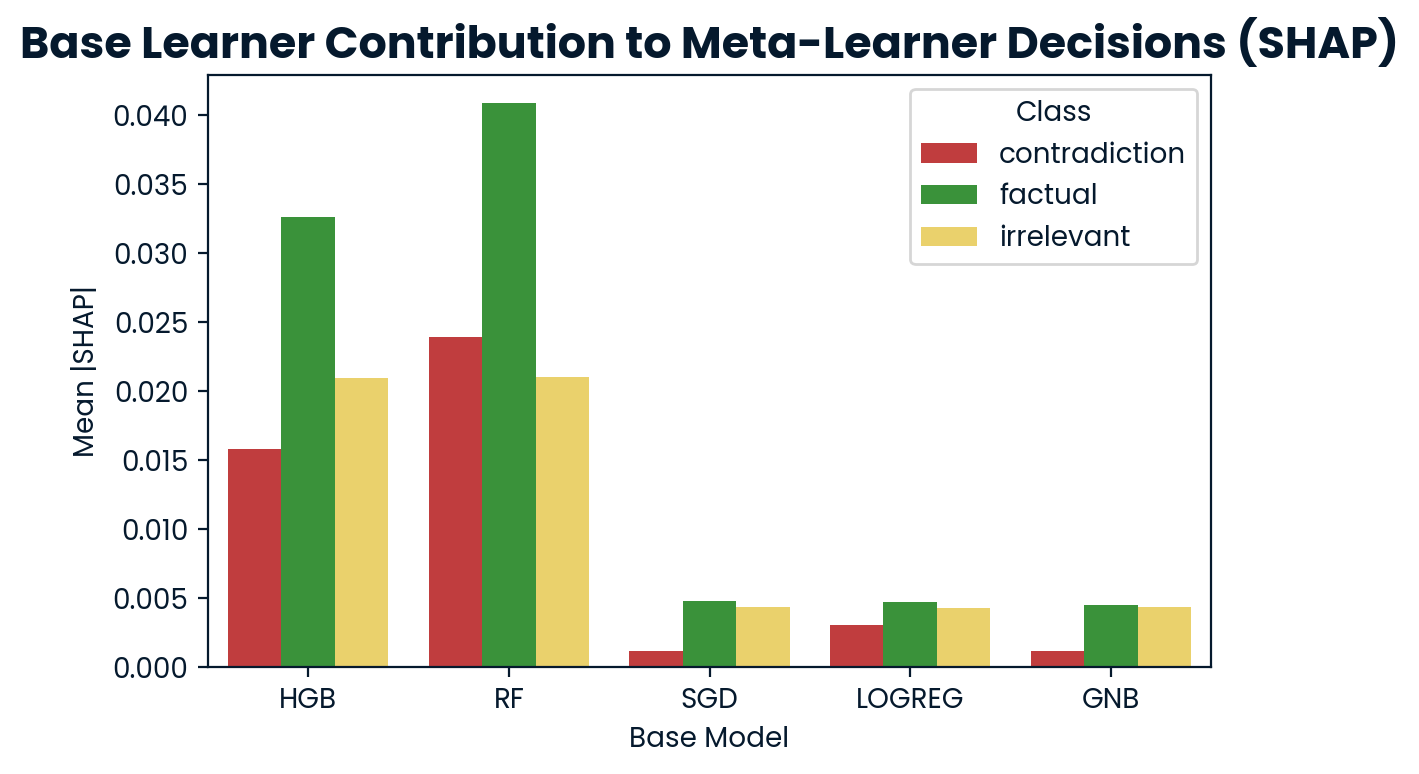

In [23]:
model_groups = {
    "HGB": [c for c in X_meta_test.columns if c.startswith("hgb_prob_")],
    "RF": [c for c in X_meta_test.columns if c.startswith("rf_prob_")],
    "SGD": [c for c in X_meta_test.columns if c.startswith("sgd_prob_")],
    "LOGREG": [c for c in X_meta_test.columns if c.startswith("logreg_prob_")],
    "GNB": [c for c in X_meta_test.columns if c.startswith("gnb_prob_")]
}
rows = []
for cls_idx, cls in enumerate(le.classes_):
    for model, cols in model_groups.items():
        idxs = [X_meta_test.columns.get_loc(c) for c in cols]
        val = np.abs(shap_values.values[:, idxs, cls_idx]).mean()
        rows.append((cls, model, val))
df_base_shap = pd.DataFrame(rows, columns=["Class", "Base Model", "Mean |SHAP|"])
palette = {cls: TRAFFIC_LIGHTS.get(cls, "#cccccc") for cls in le.classes_}
plt.figure(figsize=(6,4))
sns.barplot(
    data=df_base_shap, 
    x="Base Model", 
    y="Mean |SHAP|", 
    hue="Class", 
    palette=palette
)
plt.title("Base Learner Contribution to Meta-Learner Decisions (SHAP)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

For all classes of the `type` target, the MLP meta-learner mostly relies, however, on the two base learners Random Forest and boosting model.

This also becomes evident when looking at **the most confident mistake per target class the model made while predicting**:

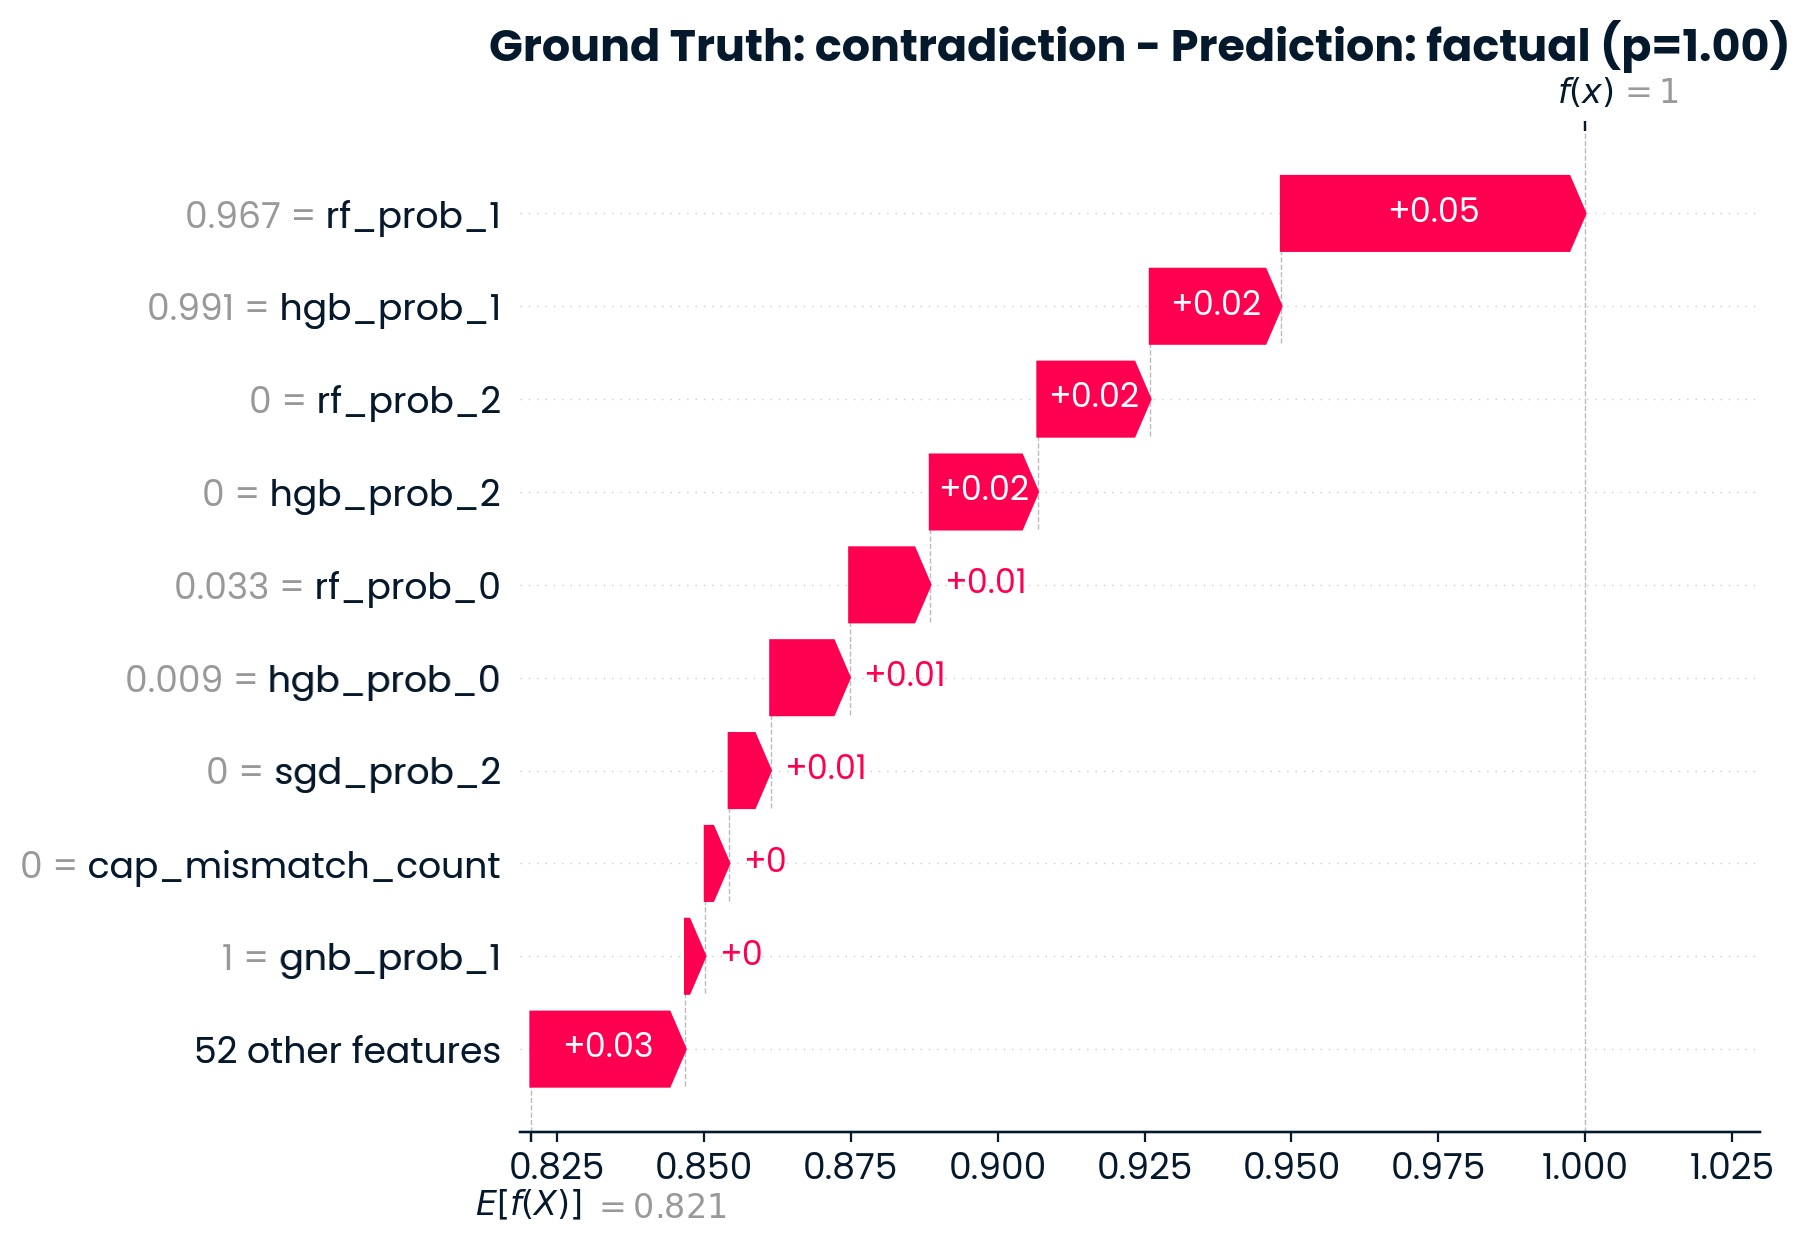

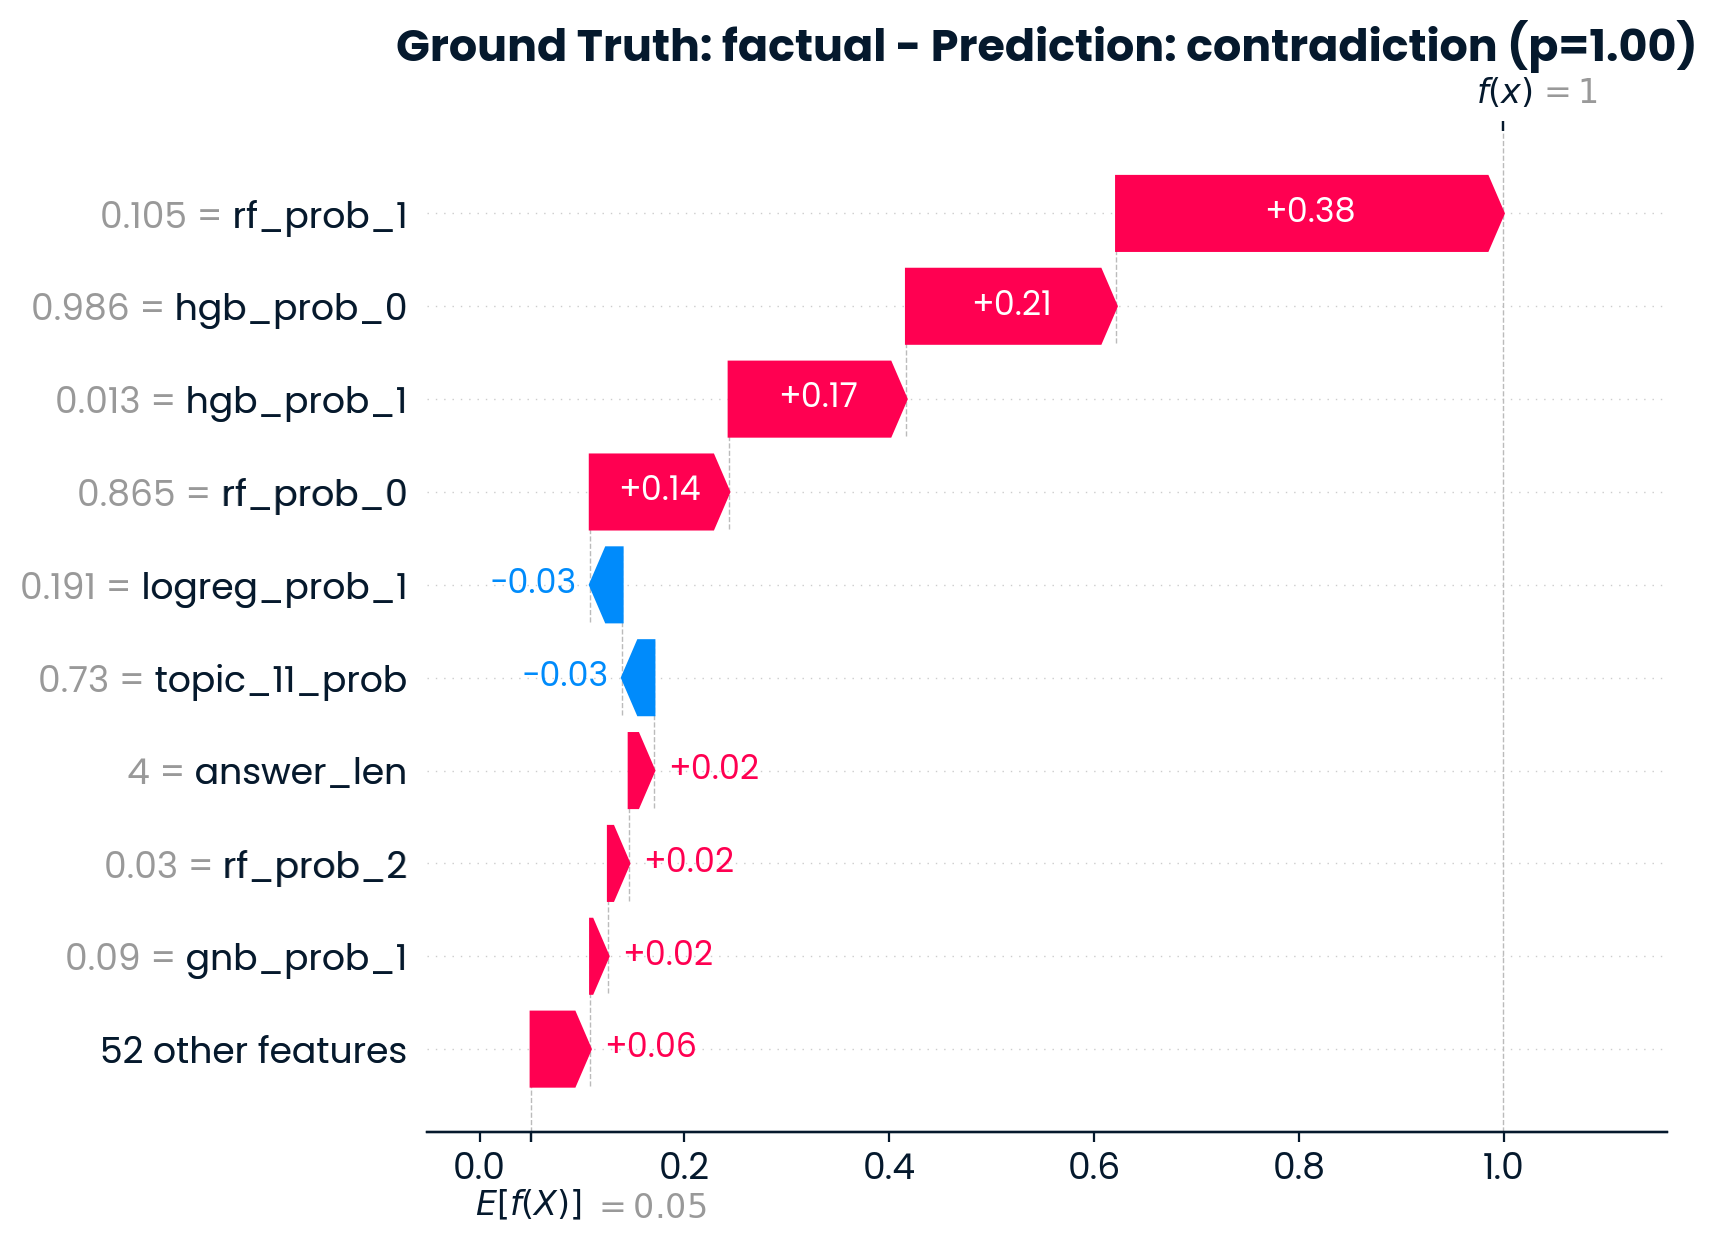

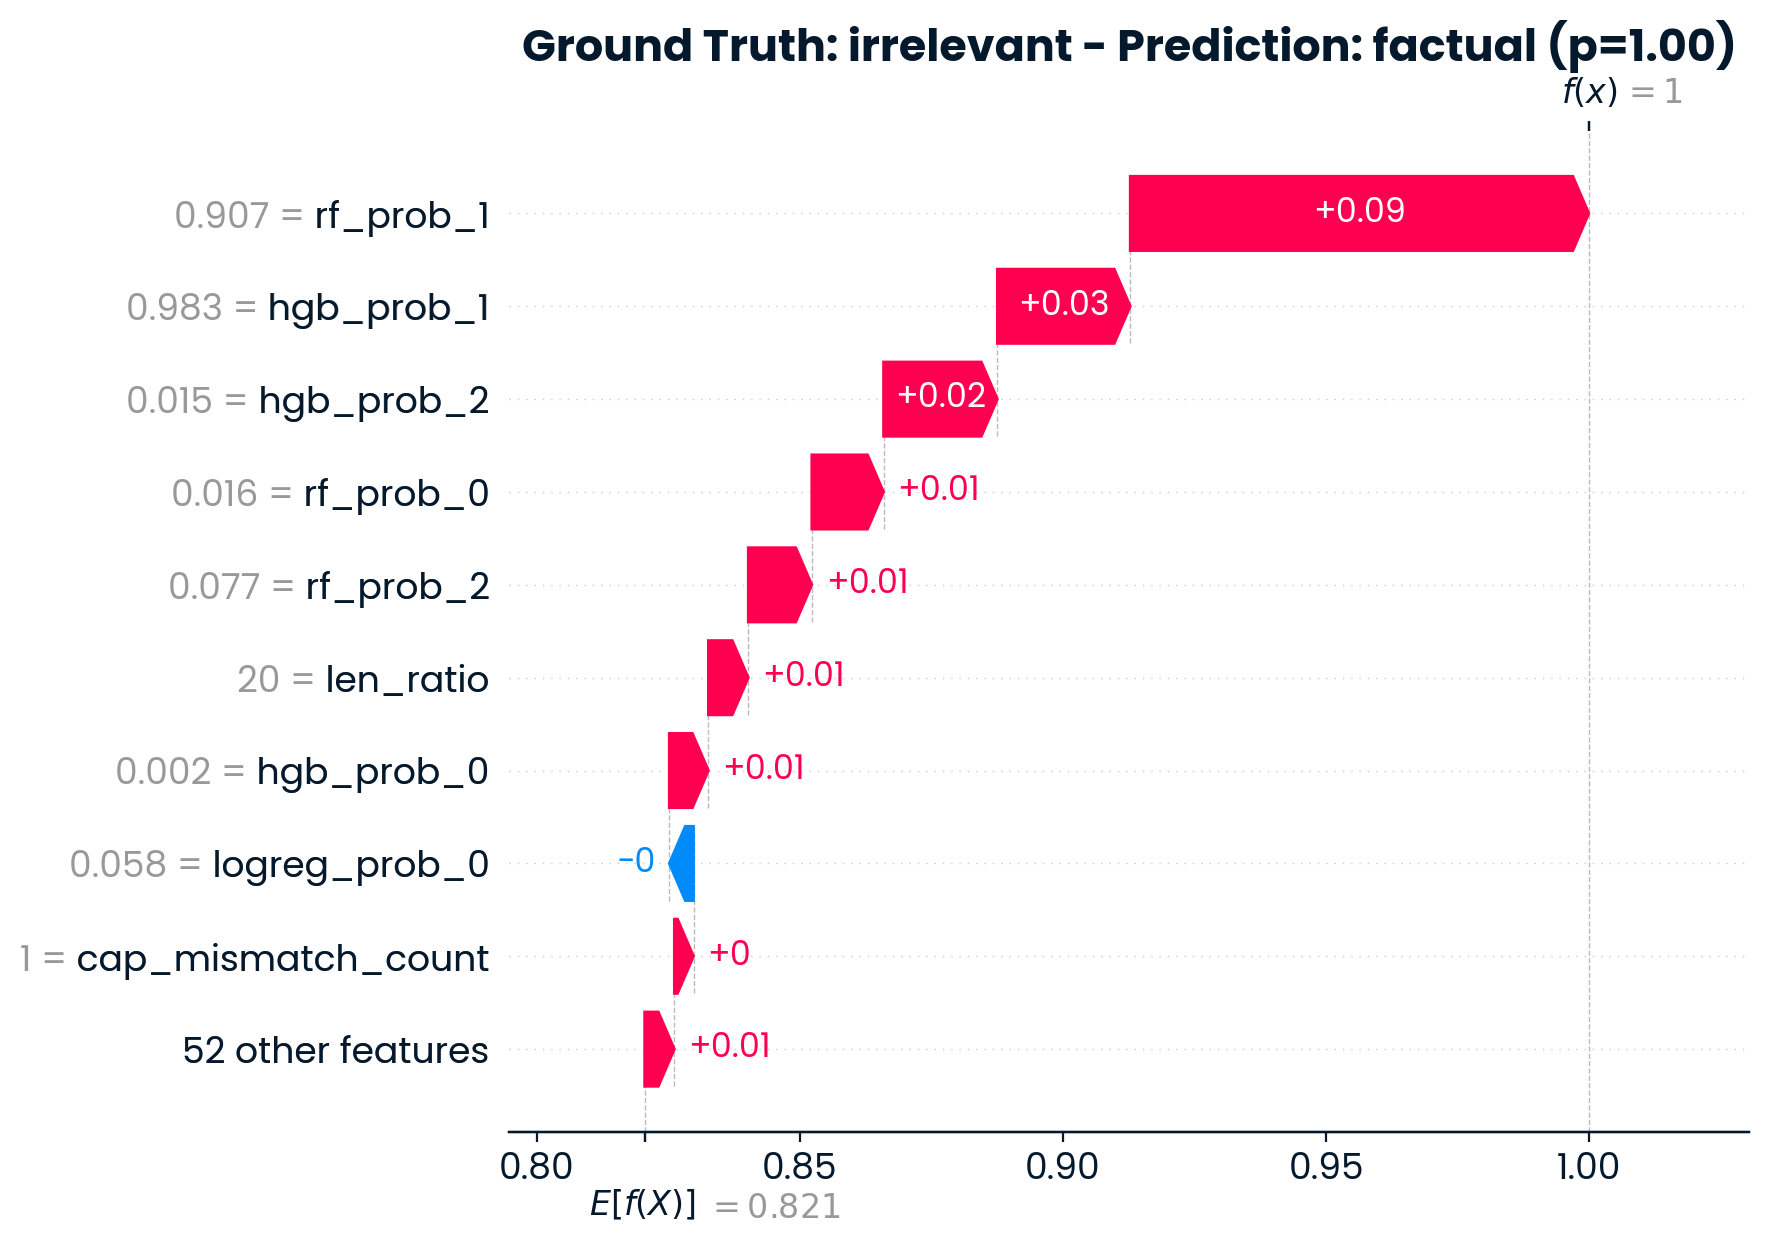

In [30]:
probas = mlp_full.predict_proba(X_meta_test)
selected_indices = []
for cls_idx, cls_name in enumerate(le.classes_):
    mask = (y_test_enc == cls_idx) & (y_pred_stack_full != y_test_enc)
    if not np.any(mask):
        continue
    class_errors = np.where(mask)[0]
    pred_probs = probas[class_errors, y_pred_stack_full[class_errors]]
    best_idx = class_errors[np.argmax(pred_probs)]
    selected_indices.append(best_idx)
for idx in selected_indices:
    true_label = le.classes_[y_test_enc[idx]]
    pred_idx = y_pred_stack_full[idx]
    pred_label = le.classes_[pred_idx]
    pred_prob = probas[idx, pred_idx]
    plt.figure(figsize=(6,4))
    shap.plots.waterfall(
        shap_values[idx, :, pred_idx],
        max_display=10,
        show=False
    )
    plt.title(f"Ground Truth: {true_label} - Prediction: {pred_label} (p={pred_prob:.2f})", fontsize=16, fontweight="bold")
    plt.show()

As the meta-features clearly dominate the importance ranking for the MLP meta-learner, when the Random Forest and the boosting model make a mistake, so does the MLP. Most base features combined only play minute roles in predictive performance.

Still, the **MLP meta-learner is a black-box model**.

Hence, I **fit an interpretable Explainable Boosting Machine (EBM) to the MLP's predictions as a surrogate model**. This allows the visualization of the precise "shape" of the decision boundaries.

**EBM surrogate fidelity (full stack) macro-F1 score is `0.9817`**, which shows very high agreement and indicates that the EBM approximates the behavior of the MLP very well. The feature importance scores - which are similar to the ones of the MLP meta-learner and the SHAP values - support this claim.

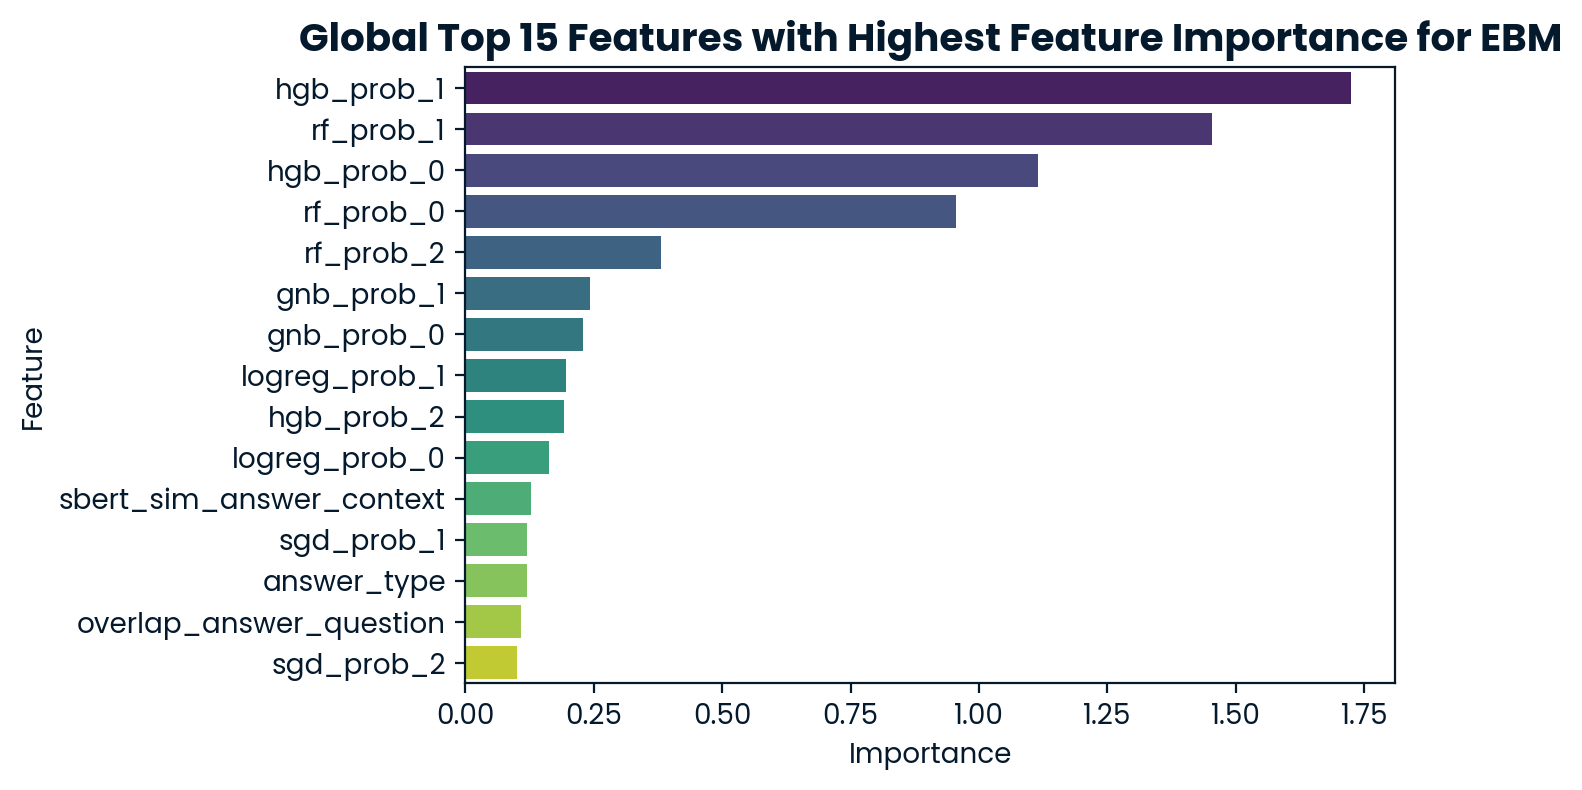

In [31]:
model_path = "intermediate_results/ebm_full_surrogate.joblib"
if os.path.exists(model_path):
    # Load model if it exists
    ebm_full = joblib.load(model_path)
else:
    # Train model if it does not exist
    mlp_full_proba_train = mlp_full.predict_proba(X_meta_train)
    surrogate_labels = np.argmax(mlp_full_proba_train, axis=1)
    ebm_full = ExplainableBoostingClassifier(random_state=42, n_jobs=-1, early_stopping_rounds=15) 
    ebm_full.fit(X_meta_train, surrogate_labels)
    # Save model for future runs
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    joblib.dump(ebm_full, model_path)

# Classification agreement
f1_full_surrogate = f1_score(
    np.argmax(mlp_full.predict_proba(X_meta_test), axis=1),
    ebm_full.predict(X_meta_test),
    average="macro"
)
from IPython.display import display, Markdown
display(Markdown(
    f"**EBM surrogate fidelity (full stack) macro-F1 score is `{f1_full_surrogate:.4f}`**, which shows very high agreement and indicates that the EBM approximates the behavior of the MLP very well."
))

# Global explanation and feature importance extraction
global_exp_full = ebm_full.explain_global()
data = global_exp_full.data()
importance_df = pd.DataFrame({
    'Feature': data['names'],
    'Importance': data['scores']
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Global Top 15 Features with Highest Feature Importance for EBM', fontsize=14, fontweight='bold')
plt.show()

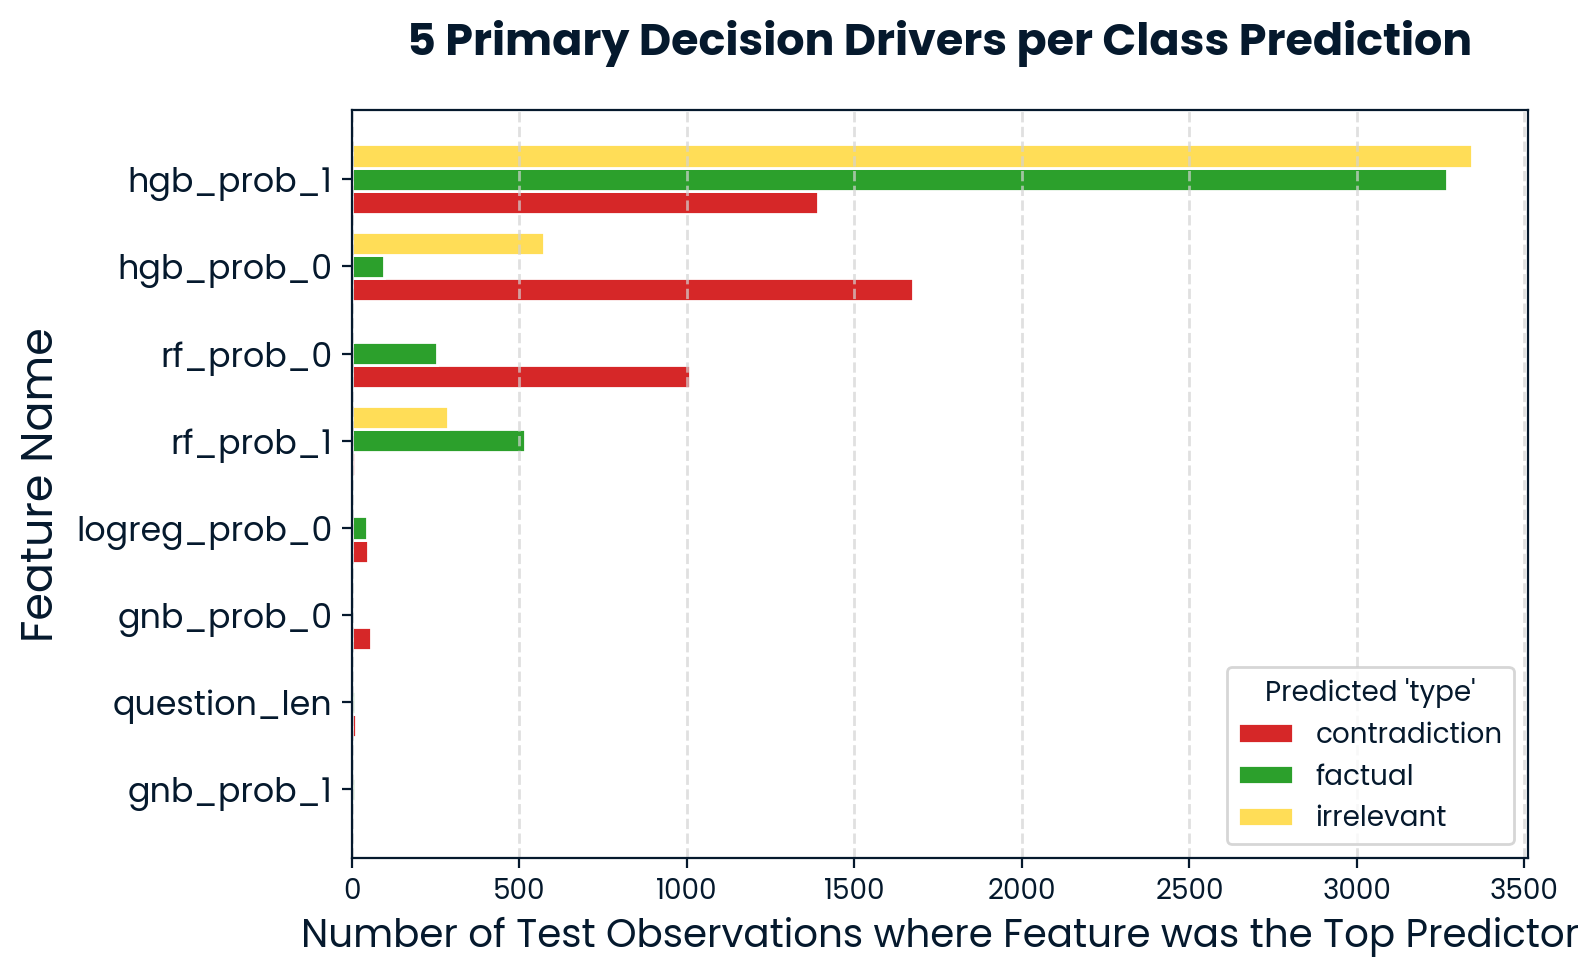

In [27]:
local_explanations = ebm_full.explain_local(X_meta_test)
summary = []
for i in range(len(X_meta_test)):
    data = local_explanations.data(i)
    for c_idx, c_name in enumerate(le.classes_):
        scores = np.array(data['scores'])
        top_feat_idx = np.argmax(np.abs(scores[:, c_idx]))
        summary.append({
            'Class': c_name,
            'Top Driver': data['names'][top_feat_idx],
            'Score': scores[top_feat_idx, c_idx]
        })
summary_df = pd.DataFrame(summary)
driver_counts = summary_df['Top Driver'].value_counts()
top_drivers_list = driver_counts[driver_counts > 5].index
filtered_summary = summary_df[summary_df['Top Driver'].isin(top_drivers_list)]
class_order = list(le.classes_)
color_map = [TRAFFIC_LIGHTS[c.lower()] for c in class_order]
driver_order = list(top_drivers_list)
driver_order = driver_order[::-1]
counts = np.zeros((len(driver_order), len(class_order)), dtype=int)
for i, driver in enumerate(driver_order):
    for j, cls in enumerate(class_order):
        counts[i, j] = ((filtered_summary['Top Driver'] == driver) & (filtered_summary['Class'] == cls)).sum()

fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
bar_width = 0.8 / len(class_order)
indices = np.arange(len(driver_order))
bars = []
for j, cls in enumerate(class_order):
    bar = ax.barh(
        indices + (j - (len(class_order)-1)/2) * bar_width,
        counts[:, j],
        height=bar_width,
        color=color_map[j],
        label=cls,
        edgecolor='white',
        linewidth=1
    )
    bars.append(bar)
ax.set_yticks(indices)
ax.set_yticklabels(driver_order, fontsize=12)
ax.set_xlabel("Number of Test Observations where Feature was the Top Predictor", fontsize=14)
ax.set_ylabel("Feature Name", fontsize=16)
ax.set_title("5 Primary Decision Drivers per Class Prediction", fontsize=16, fontweight='bold', pad=20)
ax.legend(title="Predicted 'type'", loc='lower right')
ax.grid(True, axis='x', linestyle='--', color='lightgrey', linewidth=1, alpha=0.7)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

The **feature importance scores and the primary decision drivers** - which are similar to the ones of the MLP meta-learner and the SHAP values - **support the prior claim**. Therefore, the **EBM can be used as an interpretable surrogate model for the MLP meta-learner**.

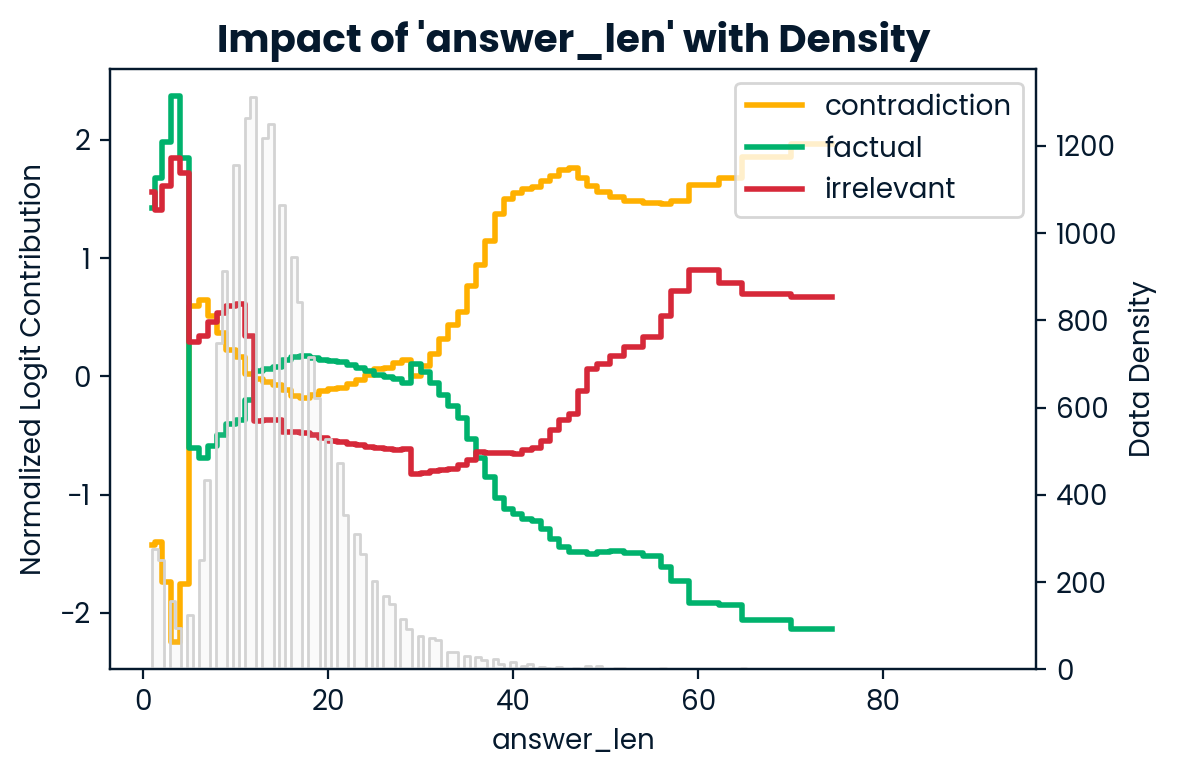

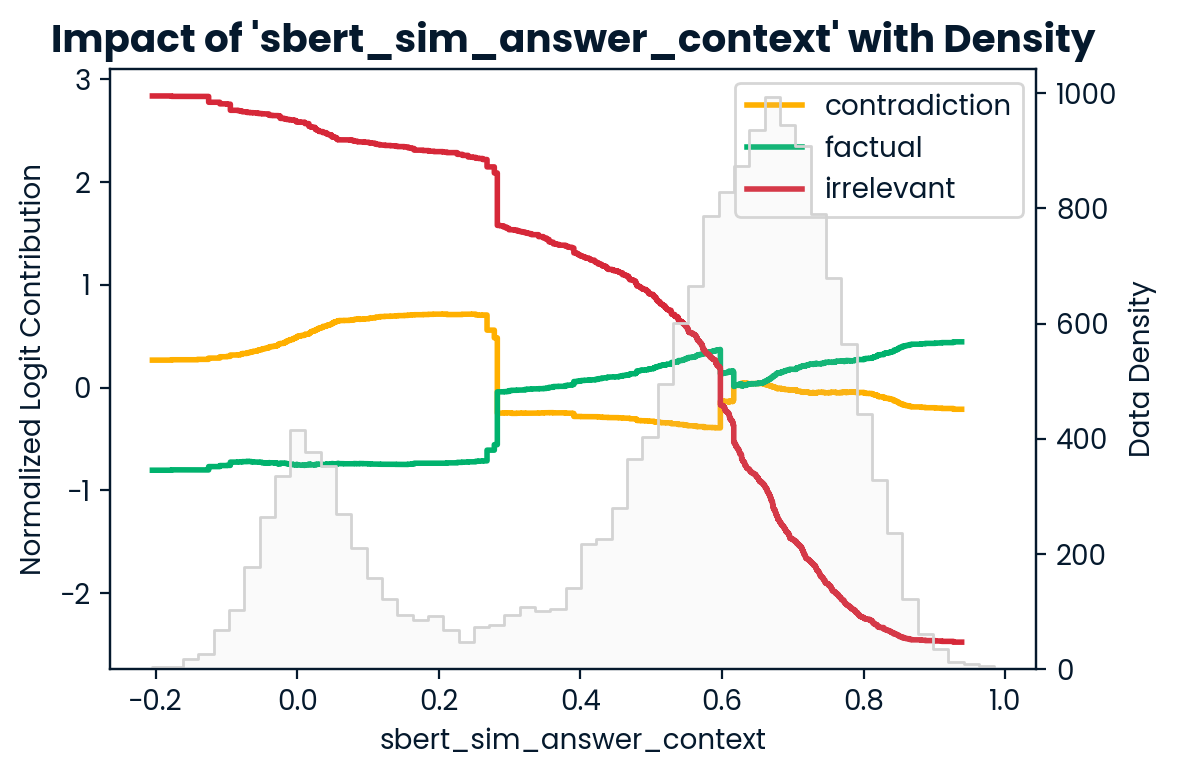

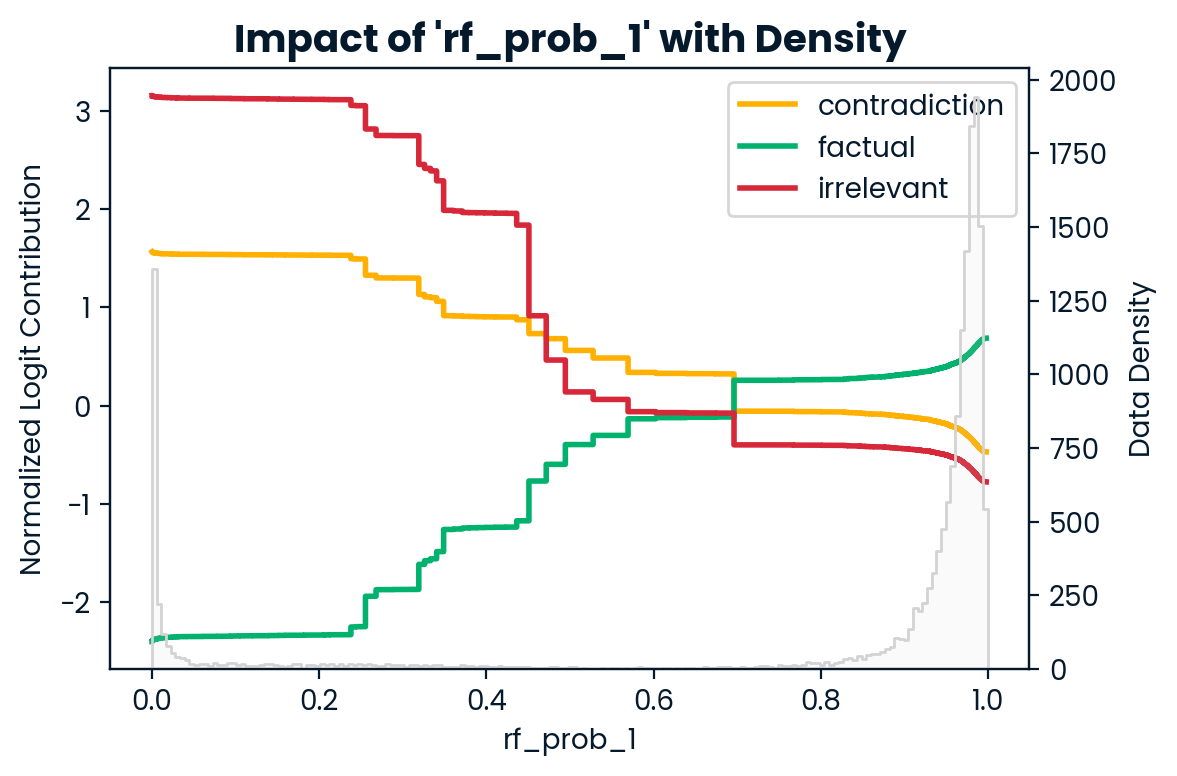

In [44]:
feature_names = ['answer_len', 'sbert_sim_answer_context', 'rf_prob_1']
configs = [
    {'idx': 0, 'name': 'contradiction', 'color': '#FFB000'},  
    {'idx': 1, 'name': 'factual', 'color': '#00B26D'},       
    {'idx': 2, 'name': 'irrelevant', 'color': '#D62839'}      
]
X_train_full = X_meta_train
col_index = {c: i for i, c in enumerate(X_train_full.columns)}

def get_mu_sigma(scores):
    arr = np.array(scores)
    mu = np.mean(arr)
    sigma = np.std(arr) if np.std(arr) > 0 else 1.0
    return mu, sigma

for feature_name in feature_names:
    feature_index = col_index[feature_name]
    feature_data = global_exp_full.data(feature_index)
    mu, sigma = get_mu_sigma(feature_data['scores'])
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax2 = ax1.twinx()
    ax2.grid(False)
    sns.histplot(X_train_full[feature_name], ax=ax2, color='lightgray', alpha=0.1, element='step', label='Data Density')
    ax2.set_ylabel('Data Density')
    for config in configs:
        y = (np.array(feature_data['scores'])[:, config['idx']] - mu) / sigma
        if 'bin_edges' in feature_data:
            bin_edges = np.array(feature_data['bin_edges'])
            x = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            if len(x) > len(y):
                x = x[:len(y)]
            elif len(x) < len(y):
                y = y[:len(x)]
        elif 'names' in feature_data:
            x = feature_data['names']
            if len(x) > len(y):
                x = x[:len(y)]
            elif len(x) < len(y):
                y = y[:len(x)]
        else:
            x = range(len(y))
        ax1.step(x, y, where='mid', color=config['color'], label=config['name'], linewidth=2)
    ax1.set_title(f"Impact of '{feature_name}' with Density", fontsize=14, fontweight='bold')
    ax1.set_xlabel(feature_name)
    ax1.set_ylabel('Normalized Logit Contribution')
    ax1.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

The **shape functions above show the exact decision boundaries of the EBM surrogate** which models the MLP's behavior, thus making the black-box model explainable.

Like the SHAP scatter plot in relation to the SBERT similarity scores suggested, interaction effects seem to be present as the **answer length has a hetergeneous effect across lengths**, which do not seem to be arbitrary. Furthermore, the probability of predicting the factual class for the target (given by the Random Forest base learner) seem to be quite linear with some exponential tendency at the extremes. 

In [53]:
y_test_pred = ebm_full.predict(X_meta_test)
macro_f1_test = f1_score(le.transform(y_test), y_test_pred, average='macro')
macro_f1_test
display(Markdown(
    f"Moreover, the fully interpretable **EBM could replace the MLP in production, should explainability be a concern**. The excellent macro F1-score of `{macro_f1_test:.4f}` is also of superior performance compared to base learners."
))

Moreover, the fully interpretable **EBM could replace the MLP in production, should explainability be a concern**. The excellent macro F1-score of `0.9161` is also of superior performance compared to base learners.

# Conclusion & Final Discussion

## Model Performance and Synergies
- Study results highlight **effectiveness of treating factuality detection as 3-class NLI problem**
- Final ensemble achieved **high macro-F1 score of 0.92**, given that a **hybrid feature set** provides a robust signal for classification
- Random Forest was strongest base learner, arguably thanks to its ability to handle non-linear interactions between diverse feature groups (Lexical, Logic, and Deep Learning)
- MLP meta-learner successfully **integrated predicted probabilities from base learners with other features** to achieve final slight performance boost
- Yet, boost ist marginal, suggesting that **"signal" captured by different models is more correlated than expected or single models mainly drive performance**
- **Interpretability/Explainability analysis reveals the later to be the case**, suggesting an EBM surrogate model for full transparency 

## What did NOT Work
- **Feature Engineering**: More advanced pre-trained models could not be loaded. For faster runtime, I uploaded the deep learning features as a csv file to the data folder.
- **Training**:
    - More advanced hyperparameter tuning techniques (such as Bayesian optimization) were not useful, as the tuning did not immensely increase performance (5 percentage points maximum), hence random search was sufficient
    - While most models benefited from more features, the first group already established a strong base line and Naive Bayes actually deteriorated with increasing amounts of features, similarly Naive Bayes performance also did not increase for minority classes when using skeptical priors, thus this idea was discarded
- **Ensembling**:
    - I tried different meta-learners for the stacking ensemble (boosting model, logistic regression) and also a soft majority voting ensemble. All performed worse than the boosting base learner and Random Forest base learner by themselves so these ideas were discarded, ultimately I chose an MLP meta learner
    - Minor hiccup during ensembling was the SGDClassifier I used intead of SVC, as it could not predict probabilities, so I used the hard labels instead)

## Insights from Interpretability/Explainability Analysis
- **Role of Logic**: logical features, particularly SBERT similarity score, might serve as critical tie-breakers in edge cases
- **Ensemble Synergy**: marginal boost from ensemble indicates that base learners are already capturing similar signals, but MLP meta-learner effectively weighs "certainty" of different models, but still mainly relies on Random Forest and gradient boosting model for predictions

## Conclusion and Future Work
- Transition from hard labels to probabilistic predictions for meta-learner was critical step in refining ensemble
- Future research could focus on developing modern Transformer model to replace current pre-trained NLI feature extraction
- Additionally, more granular "evidence entropy" features could help hybrid models better handle "irrelevant" answers that are semantically similar but factually disconnected from context